# How can frog grow its tail back?


In [ ]:
%%capture
%pip install scanpy
%pip install anndata==0.10.9
%pip install igraph
%pip install umap-learn==0.5.8
%pip install louvain
%pip install leidenalg
%pip install warnings
%pip install magic-impute
%pip install pandas
%pip install numpy==1.26.4
%pip install pyALRA
%pip install bbknn==1.6.0
%pip install harmonypy
%pip install bbknn

In [ ]:
import os
import scanpy as sc
import scanpy.external as sce
import igraph as ig
import umap
import magic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import bbknn
import warnings
# from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score

In [3]:
# Global settings
path_h5ad_local = "cleaned_processed_frogtail.h5ad"
path_h5ad_cloud = ""
path_h5ad_used = ""
path_figure_local = "figures"
path_output_local = "saved"
proj_rand_seed = 822

In [4]:
current_env = -1 # 0 = local, 1 = cloud
try: 
    from google.colab import drive
    drive.mount('/content/drive')
    current_env = 1
    path_h5ad_used = path_h5ad_cloud
except ModuleNotFoundError:
    current_env = 0
    path_h5ad_used = path_h5ad_local
    os.makedirs(path_figure_local, exist_ok=True)
    sc.settings.figdir = path_figure_local
    os.makedirs(path_output_local, exist_ok=True)

In [5]:
def project_warning(message, category, filename, lineno, line=None):
    return f"Warning: {category.__name__}: {message}\n"
warnings.formatwarning = project_warning

In [6]:
adata = sc.read_h5ad(path_h5ad_used)
adata.X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(13199, 31535))

## Starter step 1: replicate 1B

In [ ]:
sc.pp.normalize_total(data, target_sum=1e4)

hvg_params = {
    'min_mean_quantile': 0.05,
    'max_mean_quantile': 0.80,
    'min_fano_quantile': 0.65,
}

gene_means = np.asarray(data.X.mean(axis=0)).flatten()
gene_vars = np.asarray(data.X.var(axis=0, ddof=0)).flatten()

gene_fano = np.full_like(gene_means, np.nan)
np.divide(gene_vars, gene_means, where=gene_means > 0, out=gene_fano)

mean_thresh_low = np.quantile(gene_means, hvg_params['min_mean_quantile'])
mean_thresh_high = np.quantile(gene_means, hvg_params['max_mean_quantile'])
fano_thresh = np.quantile(gene_fano[np.isfinite(gene_fano)], hvg_params['min_fano_quantile'])

is_in_mean_range = (gene_means >= mean_thresh_low) & (gene_means <= mean_thresh_high)
has_high_fano = gene_fano >= fano_thresh
data.var['is_hvg'] = is_in_mean_range & has_high_fano

clustering_params = {
    'n_neighbors': 10,
    'walktrap_steps': 10,
    'umap_seed': 3,
    'clustering_seed': 8,
}

data_hvg = data[:, data.var['is_hvg']].copy()
sc.pp.log1p(data_hvg, base=2)

knn_graph, _, _ = umap.umap_.fuzzy_simplicial_set(
    X=data_hvg.X,
    n_neighbors=clustering_params['n_neighbors'],
    random_state=clustering_params['umap_seed'],
    metric='cosine'
)

igraph_graph = ig.Graph.Weighted_Adjacency(knn_graph.toarray(), mode='undirected')
np.random.seed(clustering_params['clustering_seed'])
walktrap_partition = igraph_graph.community_walktrap(weights='weight', steps=clustering_params['walktrap_steps'])
cluster_labels = walktrap_partition.as_clustering().membership

data.obs['walktrap_labels'] = pd.Series(cluster_labels, index=data.obs_names, dtype="category")

umap_viz_params = {
    'n_neighbors': 20,
    'min_dist': 0.5,
    'random_state': 32,
    'metric': 'cosine'
}

sc.pp.neighbors(
    data_hvg,
    n_neighbors=umap_viz_params['n_neighbors'],
    random_state=umap_viz_params['random_state'],
    metric=umap_viz_params['metric'],
    use_rep='X'
)
sc.tl.umap(
    data_hvg,
    min_dist=umap_viz_params['min_dist'],
    random_state=umap_viz_params['random_state']
)

data.obsm['X_umap'] = data_hvg.obsm['X_umap']

colors_df = pd.read_csv('cluster_color_hex.csv')
color_map = colors_df.set_index('names')['cols'].to_dict()

observed_categories = data.obs['cluster'].cat.categories
custom_palette = [color_map.get(cat, '#808080') for cat in observed_categories]

plot_kwargs = {
    'color': 'cluster',
    'palette': custom_palette,
    'frameon': False,
    's': 12,
    'legend_loc': 'right margin',
    'title': 'UMAP replication of figure 1B'
}

sc.pl.umap(data, **plot_kwargs)

## Step 2 Base Clustering

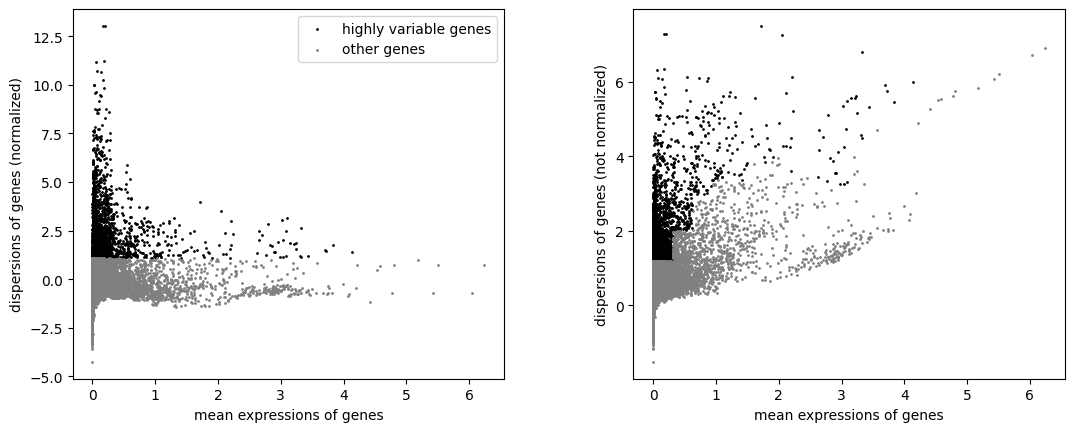

In [8]:
# Preprocessing from template
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2300)
# Plot 1
sc.pl.highly_variable_genes(adata)

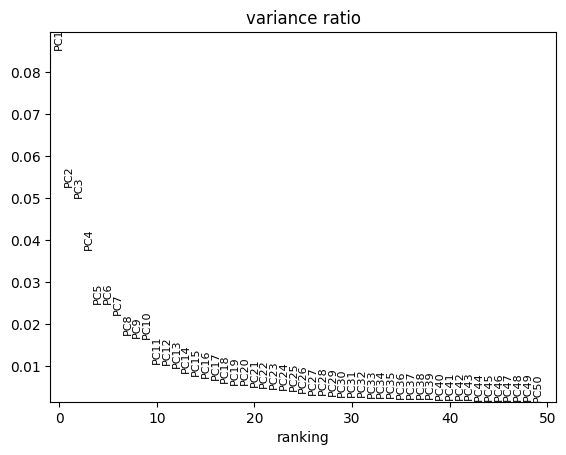

In [9]:
adata_hvg = adata[:, adata.var.highly_variable]
sc.pp.scale(adata_hvg, max_value=10)
sc.pp.pca(adata_hvg, n_comps=50)
# Plot 2
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50, log=False)

In [10]:
# Choose pcs after inspecting
sc.pp.neighbors(
    adata_hvg,
    n_neighbors=15,
    n_pcs=40,
    random_state=proj_rand_seed
)
reference_labels = adata_hvg.obs['cluster']
target_cluster_count = adata_hvg.obs['cluster'].nunique()
pca_embedding = adata_hvg.obsm['X_pca']

print(f'Reference column has {target_cluster_count:.0f} clusters')

Reference column has 46 clusters


### PCA + Leiden

Manually choosen res=1.93


 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


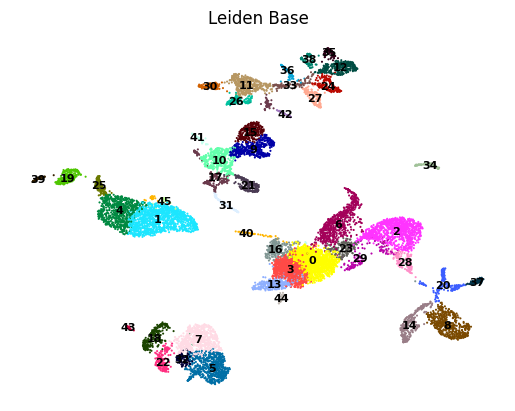

In [11]:
sc.tl.leiden(adata_hvg, resolution=1.93, key_added='leiden_clusters', random_state=proj_rand_seed)
sc.tl.umap(adata_hvg)
sc.pl.umap(
    adata_hvg,
    color='leiden_clusters',
    title='Leiden Base',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_leiden_base.png'
)

### PCA + GMM

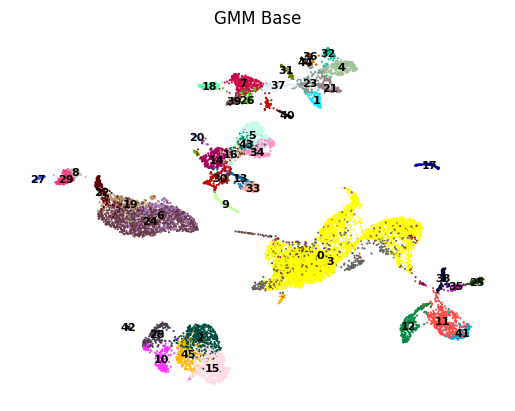

In [12]:
gmm_model = GaussianMixture(
    n_components=target_cluster_count,
    covariance_type='full',
    random_state=proj_rand_seed,
    reg_covar=1e-5 # This is increased from default otherwise an error is thrown
)
gmm_predictions = gmm_model.fit_predict(pca_embedding)
adata_hvg.obs['gmm_clusters'] = pd.Categorical(gmm_predictions.astype(str))
sc.pl.umap(
    adata_hvg,
    color='gmm_clusters',
    title='GMM Base',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save="_gmm_base.png"
)

### PCA + K-Means

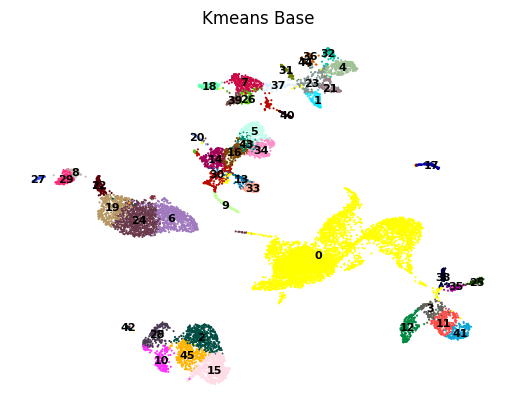

In [10]:
kmeans_model = KMeans(
    n_clusters=target_cluster_count,
    random_state=proj_rand_seed,
    n_init='auto'
)
kmeans_predictions = kmeans_model.fit_predict(pca_embedding)
adata_hvg.obs['kmeans_clusters'] = pd.Categorical(kmeans_predictions.astype(str))

# Plotting
sc.pl.umap(
    adata_hvg,
    color='kmeans_clusters',
    title='Kmeans Base',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_k_means_base.png'
)

### Comparing Metrics

In [11]:
cluster_metrics = {}
cluster_metrics['leiden'] = {}
cluster_metrics['gmm'] = {}
cluster_metrics['kmeans'] = {}

for method_name in cluster_metrics.keys():
    temp_string = f'{method_name}_clusters'
    cluster_metrics[method_name]['silhouette'] = silhouette_score(
        pca_embedding, 
        adata_hvg.obs[temp_string]
    )
for method_name in cluster_metrics.keys():
    temp_string = f'{method_name}_clusters'
    cluster_metrics[method_name]['davies_bouldin'] = davies_bouldin_score(
        pca_embedding, 
        adata_hvg.obs[temp_string]
    )
for method_name in cluster_metrics.keys():
    temp_string = f'{method_name}_clusters'
    cluster_metrics[method_name]['calinski_harabasz'] = calinski_harabasz_score(
        pca_embedding, 
        adata_hvg.obs[temp_string]
    )

cluster_metrics_df = pd.DataFrame(cluster_metrics).T
cluster_metrics_df

silhouette  davies_bouldin  calinski_harabasz
leiden    0.214973        1.223975        1530.755010
gmm       0.214750        1.525976        1510.567974
kmeans    0.448316        1.161730        1899.727252

## Marker Identification

In [5]:
# Put condition into groups
condition_map = {
    "ST40_0": "Group 1",
    "ST40_1": "Group 2",
    "ST40_2": "Group 2",
    "ST40_3": "Group 2",
    "ST46_0": "Group 3",
    "ST46_1": "Group 4",
}
adata_hvg.obs['Group'] = adata_hvg.obs['Condition'].map(condition_map)

In [6]:
# Identify the top 50 genes
gene_list = adata.var_names
sc.tl.rank_genes_groups(
    adata_hvg, 
    groupby="cluster", 
    groups=['Epidermis', 'laminin-rich epidermis'], 
    method='t-test',
    key_added="cluster_ttest_rank",
    n_genes=50
)
epidermis_markers_df = pd.DataFrame(adata_hvg.uns['cluster_ttest_rank']['names'])[['Epidermis', 'laminin-rich epidermis']]
epidermis_markers_df
# Put two columns together
epidermis_markers_epidermis = epidermis_markers_df['Epidermis'].head(50).tolist()
epidermis_markers_laminin = epidermis_markers_df['laminin-rich epidermis'].head(50).tolist()
epidermis_markers = list(set(epidermis_markers_epidermis + epidermis_markers_laminin))

In [7]:
sc.tl.score_genes(
    adata_hvg,
    gene_list = epidermis_markers,
    score_name = 'epidermis_score',
    use_raw = True
)

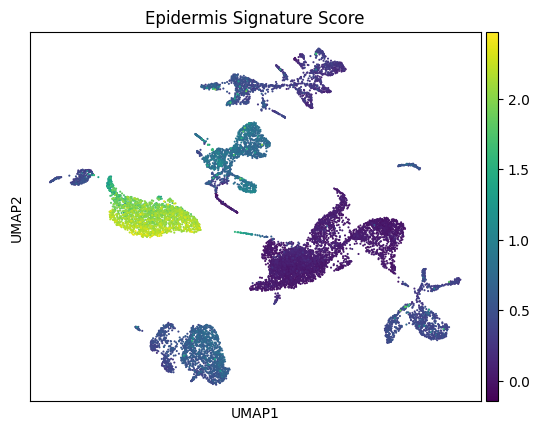

In [8]:
sc.pl.umap(
    adata_hvg,
    color='epidermis_score',
    title='Epidermis Signature Score',
    save='_epidermis_signature_score.png'
)

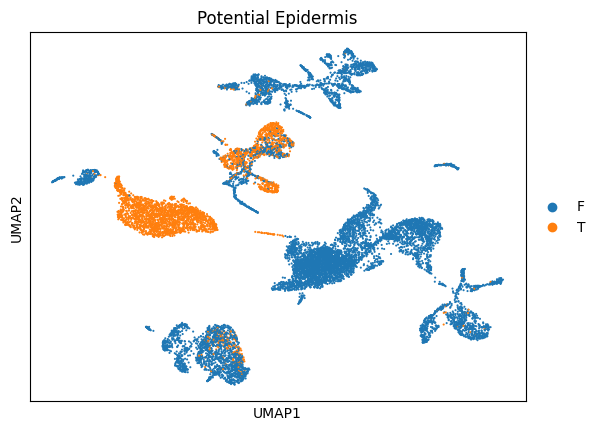

In [9]:
epidermis_high_expression = adata_hvg.obs['epidermis_score'] > adata_hvg.obs['epidermis_score'].quantile(0.75)
adata_hvg.obs['epidermis_like'] = np.where(epidermis_high_expression, "T", "F")
sc.pl.umap(
    adata_hvg,
    color='epidermis_like',
    title='Potential Epidermis',
    save='_potential epidermis.png'
)

In [10]:
adata_hvg_epidermis = adata_hvg[epidermis_high_expression, :].copy()

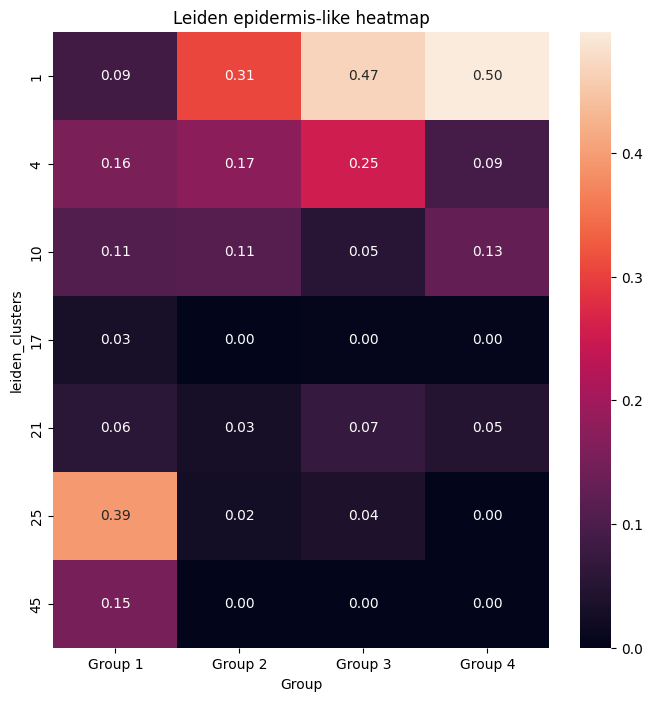

In [18]:
crosstab_group = pd.crosstab(
    adata_hvg_epidermis.obs['leiden_clusters'],
    adata_hvg_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("Leiden epidermis-like heatmap")
plt.show()

Cluster 4, 25, have the necessary feature.

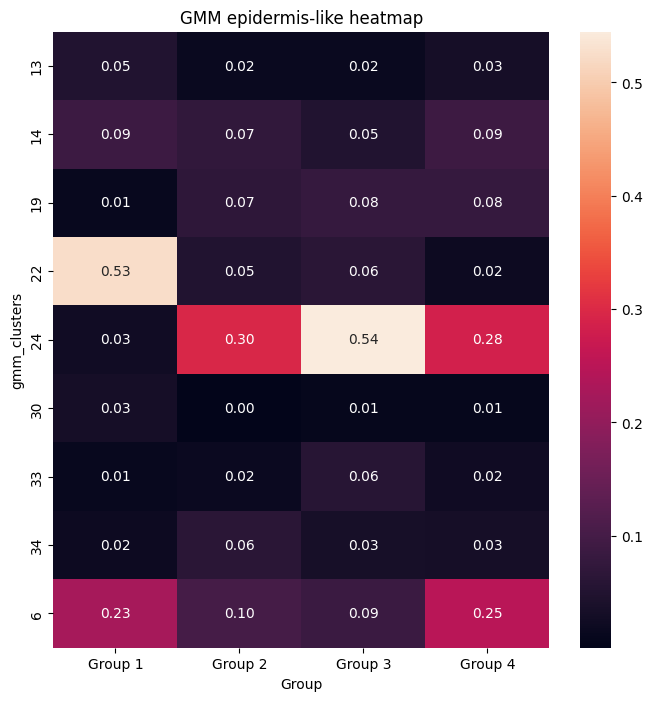

In [19]:
crosstab_group = pd.crosstab(
    adata_hvg_epidermis.obs['gmm_clusters'],
    adata_hvg_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("GMM epidermis-like heatmap")
plt.show()

Cluster 22 fit the description

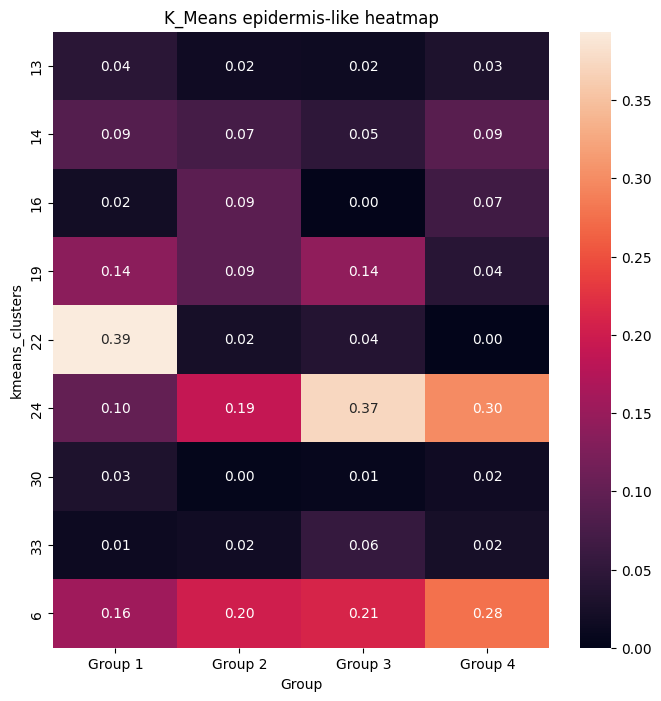

In [20]:
crosstab_group = pd.crosstab(
    adata_hvg_epidermis.obs['kmeans_clusters'],
    adata_hvg_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("K_Means epidermis-like heatmap")
plt.show()

Both 22 and 19 fit the description

In [21]:
# Store top 50 marker
marker_logreg_top_50 = {}
marker_wilcox_top_50 = {}

In [22]:
# marker id - reference col
clusters_to_id = ['ROCs']
adata_hvg.obs['marker_id_target'] = 'Ignore'
adata_hvg.obs.loc[adata_hvg.obs['cluster'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

In [23]:
# marker id - reference - logreg
sc.tl.rank_genes_groups(
    adata_hvg,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'reference_logreg_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_top_50['reference'] = marker_id_result_50

In [ ]:
# marker id - reference - wilcox
sc.tl.rank_genes_groups(
    adata_hvg,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'reference_wilcox_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_top_50['reference'] = marker_id_result_50

In [25]:
# marker id - leiden
clusters_to_id = ['25', '4']
adata_hvg.obs['marker_id_target'] = 'Ignore'
adata_hvg.obs.loc[adata_hvg.obs['leiden_clusters'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

In [26]:
# marker id - leiden - logreg
sc.tl.rank_genes_groups(
    adata_hvg,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'leiden_logreg_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_top_50['leiden'] = marker_id_result_50

In [ ]:
# marker id - leiden - wilcox
sc.tl.rank_genes_groups(
    adata_hvg,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'leiden_wilcox_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_top_50['leiden'] = marker_id_result_50

In [28]:
# marker id - gmm
clusters_to_id = ['22']
adata_hvg.obs['marker_id_target'] = 'Ignore'
adata_hvg.obs.loc[adata_hvg.obs['gmm_clusters'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

In [29]:
# marker id - gmm - logreg
sc.tl.rank_genes_groups(
    adata_hvg,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'gmm_logreg_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_top_50['gmm'] = marker_id_result_50

In [ ]:
# marker id - gmm - wilcox
sc.tl.rank_genes_groups(
    adata_hvg,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'gmm_wilcox_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_top_50['gmm'] = marker_id_result_50

In [31]:
# marker id - kmeans
clusters_to_id = ['22', '19']
adata_hvg.obs['marker_id_target'] = 'Ignore'
adata_hvg.obs.loc[adata_hvg.obs['kmeans_clusters'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

In [32]:
# marker id - gmm - logreg
sc.tl.rank_genes_groups(
    adata_hvg,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'kmeans_logreg_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_top_50['kmeans'] = marker_id_result_50

In [ ]:
# marker id - gmm - wilcox
sc.tl.rank_genes_groups(
    adata_hvg,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'kmeans_wilcox_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_top_50['kmeans'] = marker_id_result_50

### Marker Gene Compare

In [34]:
marker_mtx_colnames = list(marker_logreg_top_50.keys())
marker_overlap_mtx = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_logreg_top_50[marker_mtx_colnames[i]]
        list2 = marker_logreg_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx

reference  leiden   gmm  kmeans
reference       50.0    16.0  26.0    22.0
leiden          16.0    50.0  17.0    32.0
gmm             26.0    17.0  50.0    24.0
kmeans          22.0    32.0  24.0    50.0

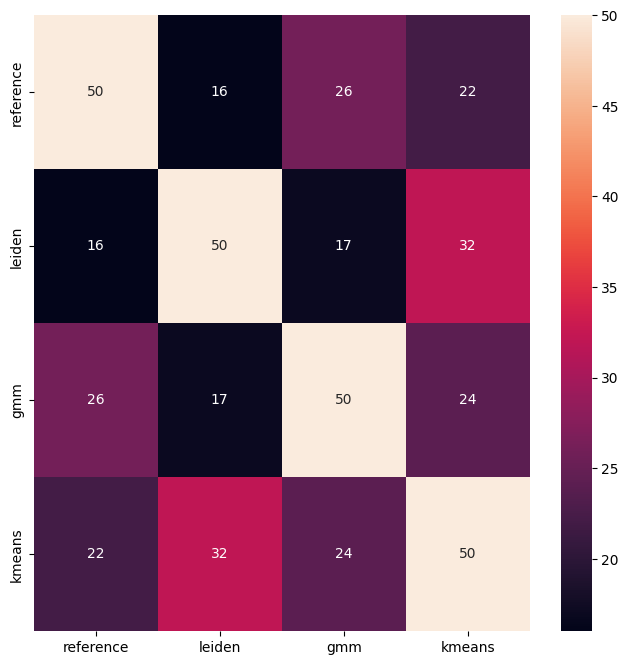

In [35]:
plt.figure(figsize=(8, 8))
sns.heatmap(
    marker_overlap_mtx,
    annot=True,
    fmt='.0f'
)
plt.show()

GMM agrees more with reference, while leiden agrees more with kmeans.

In [36]:
# Same procedure for wilcox
marker_mtx_colnames = list(marker_wilcox_top_50.keys())
marker_overlap_mtx = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_wilcox_top_50[marker_mtx_colnames[i]]
        list2 = marker_wilcox_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx

reference  leiden   gmm  kmeans
reference       50.0    31.0  50.0    36.0
leiden          31.0    50.0  31.0    44.0
gmm             50.0    31.0  50.0    36.0
kmeans          36.0    44.0  36.0    50.0

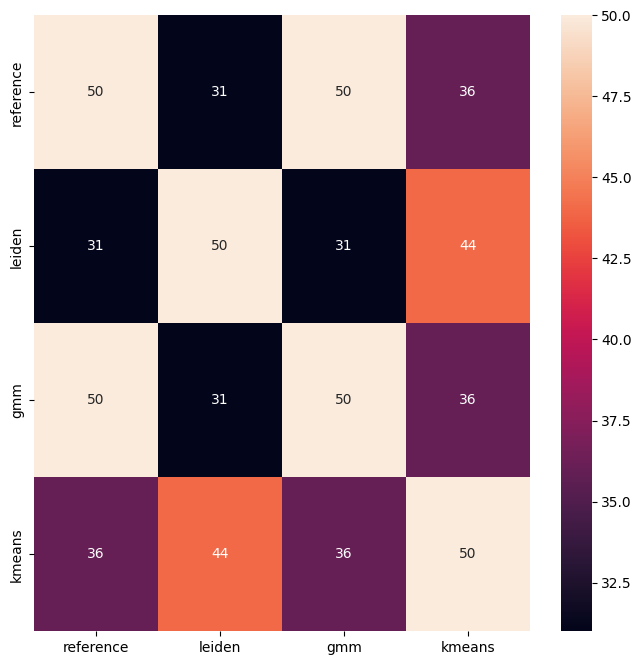

In [37]:
plt.figure(figsize=(8, 8))
sns.heatmap(
    marker_overlap_mtx,
    annot=True,
    fmt='.0f'
)
plt.show()

GMM agrees more with reference, while leiden agrees more with kmeans.

In [38]:
# Now compare with table 3
table_3_list = pd.read_csv('table3_genes.csv', header=None).iloc[:, 0].tolist()
table_3_set = set(table_3_list)

marker_mtx_colnames = list(marker_wilcox_top_50.keys())
marker_overlap_mtx = pd.DataFrame(
    index=['vs. table3'],
    columns=list(marker_mtx_colnames),
    dtype=int
)

for colname in marker_mtx_colnames:
    list1 = marker_wilcox_top_50[colname]
    list1_standardized = {gene.split('.')[0] for gene in list1}

    marker_overlap_mtx_val = len(
        list1_standardized.intersection(table_3_set)
    )
    marker_overlap_mtx.loc['vs. table3', colname] = marker_overlap_mtx_val

marker_overlap_mtx

reference  leiden  gmm  kmeans
vs. table3        7.0     2.0  7.0     2.0

Agrees with earlier results, reference and gmm performance are similar, though all 4 are not great.

## Denoising

In [ ]:
adata = sc.read_h5ad(path_h5ad_used)
adata.X.todense()

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2300)

adata_hvg = adata[:, adata.var.highly_variable].copy()
sc.pp.scale(adata_hvg, max_value=10)
sc.pp.pca(adata_hvg, n_comps=50)

sc.pp.neighbors(
    adata_hvg,
    n_neighbors=15,
    n_pcs=40,
    random_state=proj_rand_seed
)
sc.tl.umap(adata_hvg)

### MAGIC

In [ ]:
# MAGIC pp1
magic_denoiser = magic.MAGIC(t=3, random_state=proj_rand_seed)
adata.layers['magic'] = magic_denoiser.fit_transform(adata.layers['counts'])

In [15]:
# MAGIC pp2
# Take note of the copying of adata here, less thing is being copied than usual
# to save memory, this may throw an error sometime
adata.layers['magic_log'] = sc.pp.log1p(adata.layers['magic'], copy=True)
sc.pp.highly_variable_genes(adata, layer='magic_log', n_top_genes=2300)
adata_hvg_magic = adata[:, adata.var.highly_variable].copy()
adata_hvg_magic.X = adata_hvg_magic.layers['magic_log'].copy()
sc.pp.scale(adata_hvg_magic, max_value=10)
sc.pp.pca(adata_hvg_magic, random_state=proj_rand_seed)

In [16]:
# MAGIC pp3
sc.pp.neighbors(
    adata_hvg_magic, 
    n_neighbors=15, 
    n_pcs=40,
    random_state=proj_rand_seed
)
reference_labels = adata_hvg_magic.obs['cluster']
target_cluster_count = adata_hvg_magic.obs['cluster'].nunique()
pca_embedding_magic = adata_hvg_magic.obsm['X_pca']
sc.tl.umap(adata_hvg_magic)

print(f'Reference column has {target_cluster_count:.0f} clusters')

Reference column has 46 clusters


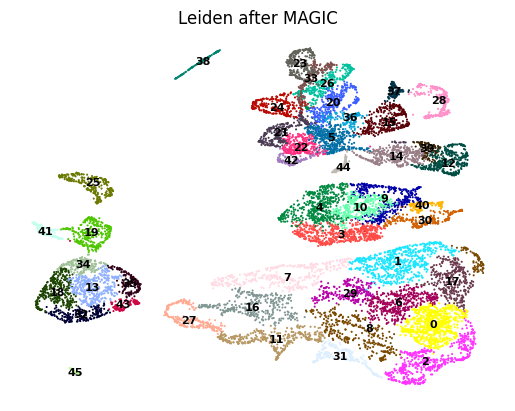

In [17]:
# MAGIC leiden 1
sc.tl.leiden(
    adata_hvg_magic, 
    resolution=1.34, 
    key_added='leiden_clusters_magic', 
    random_state=proj_rand_seed
)
sc.pl.umap(
    adata_hvg_magic,
    color='leiden_clusters_magic',
    title='Leiden after MAGIC',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_leiden_magic.png'
)

In [18]:
n_clusters_found = len(adata_hvg_magic.obs['leiden_clusters_magic'].unique())
n_clusters_found

46

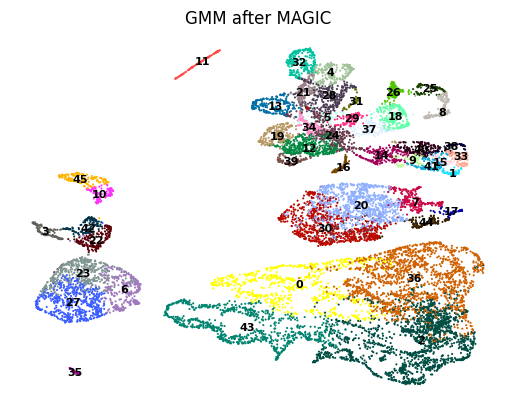

In [19]:
# MAGIC GMM 1
gmm_model = GaussianMixture(
    n_components=target_cluster_count,
    covariance_type='full',
    random_state=proj_rand_seed,
    reg_covar=1e-5
)
gmm_predictions_magic = gmm_model.fit_predict(pca_embedding_magic)
adata_hvg_magic.obs['gmm_clusters_magic'] = pd.Categorical(gmm_predictions_magic.astype(str))
sc.pl.umap(
    adata_hvg_magic,
    color='gmm_clusters_magic',
    title='GMM after MAGIC',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save="_gmm_magic.png"
)

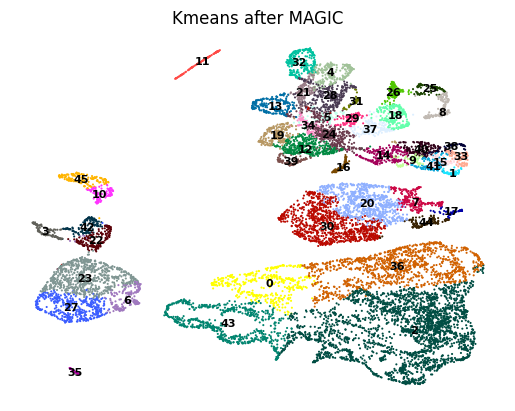

In [20]:
# MAGIC Kmeans 1
kmeans_model = KMeans(
    n_clusters=target_cluster_count,
    random_state=proj_rand_seed,
    n_init='auto'
)
kmeans_predictions_magic = kmeans_model.fit_predict(pca_embedding_magic)
adata_hvg_magic.obs['kmeans_clusters_magic'] = pd.Categorical(kmeans_predictions_magic.astype(str))

sc.pl.umap(
    adata_hvg_magic,
    color='kmeans_clusters_magic',
    title='Kmeans after MAGIC',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_k_means_magic.png'
)

In [21]:
cluster_metrics_magic = {}
cluster_metrics_magic['leiden'] = {}
cluster_metrics_magic['gmm'] = {}
cluster_metrics_magic['kmeans'] = {}

for method_name in cluster_metrics_magic.keys():
    temp_string = f'{method_name}_clusters_magic'
    cluster_metrics_magic[method_name]['silhouette'] = silhouette_score(
        pca_embedding_magic, 
        adata_hvg_magic.obs[temp_string]
    )
for method_name in cluster_metrics_magic.keys():
    temp_string = f'{method_name}_clusters_magic'
    cluster_metrics_magic[method_name]['davies_bouldin'] = davies_bouldin_score(
        pca_embedding_magic, 
        adata_hvg_magic.obs[temp_string]
    )
for method_name in cluster_metrics_magic.keys():
    temp_string = f'{method_name}_clusters_magic'
    cluster_metrics_magic[method_name]['calinski_harabasz'] = calinski_harabasz_score(
        pca_embedding_magic, 
        adata_hvg_magic.obs[temp_string]
    )

cluster_metrics_df_magic = pd.DataFrame(cluster_metrics_magic).T
cluster_metrics_df_magic

silhouette  davies_bouldin  calinski_harabasz
leiden    0.236010        1.176867        2050.601562
gmm       0.275820        1.076348        2750.654053
kmeans    0.354028        1.033053        2931.323242

Improvement for leiden on all 3;

Improvement for gmm on all 3;

The SIL for kmeans droped

In [22]:
condition_map = {
    "ST40_0": "Group 1",
    "ST40_1": "Group 2",
    "ST40_2": "Group 2",
    "ST40_3": "Group 2",
    "ST46_0": "Group 3",
    "ST46_1": "Group 4",
}
adata_hvg_magic.obs['Group'] = adata_hvg_magic.obs['Condition'].map(condition_map)

In [23]:
gene_list = adata.var_names
sc.tl.rank_genes_groups(
    adata_hvg_magic, 
    groupby="cluster", 
    groups=['Epidermis', 'laminin-rich epidermis'], 
    method='t-test',
    key_added="cluster_ttest_rank",
    n_genes=50
)
epidermis_markers_magic_df = pd.DataFrame(adata_hvg_magic.uns['cluster_ttest_rank']['names'])[['Epidermis', 'laminin-rich epidermis']]
epidermis_markers_magic_df
# Put two columns together
epidermis_markers_epidermis = epidermis_markers_magic_df['Epidermis'].head(50).tolist()
epidermis_markers_laminin = epidermis_markers_magic_df['laminin-rich epidermis'].head(50).tolist()
epidermis_markers_magic = list(set(epidermis_markers_epidermis + epidermis_markers_laminin))

In [24]:
sc.tl.score_genes(
    adata_hvg_magic,
    gene_list = epidermis_markers_magic,
    score_name = 'epidermis_score',
    use_raw = True
)

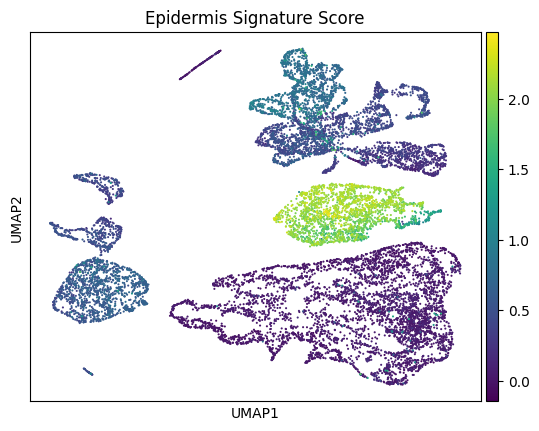

In [25]:
sc.pl.umap(
    adata_hvg_magic,
    color='epidermis_score',
    title='Epidermis Signature Score'
)

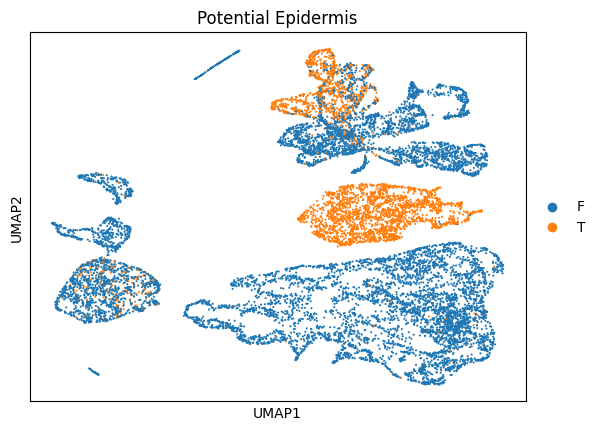

In [26]:
epidermis_high_expression = adata_hvg_magic.obs['epidermis_score'] > adata_hvg_magic.obs['epidermis_score'].quantile(0.75)
adata_hvg_magic.obs['epidermis_like'] = np.where(epidermis_high_expression, "T", "F")
sc.pl.umap(
    adata_hvg_magic,
    color='epidermis_like',
    title='Potential Epidermis'
)

In [27]:
adata_hvg_magic_epidermis = adata_hvg_magic[epidermis_high_expression, :].copy()

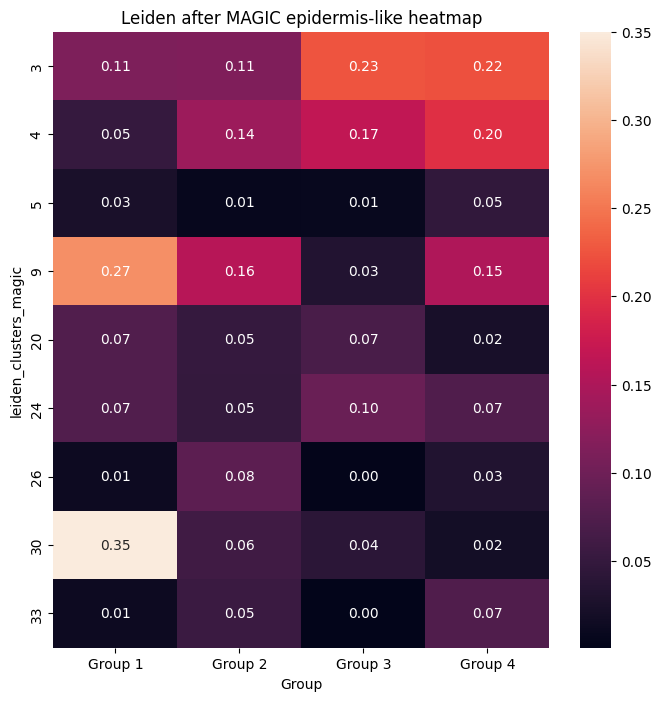

In [28]:
crosstab_group = pd.crosstab(
    adata_hvg_magic_epidermis.obs['leiden_clusters_magic'],
    adata_hvg_magic_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("Leiden after MAGIC epidermis-like heatmap")
plt.show()

Cluster 20, 30

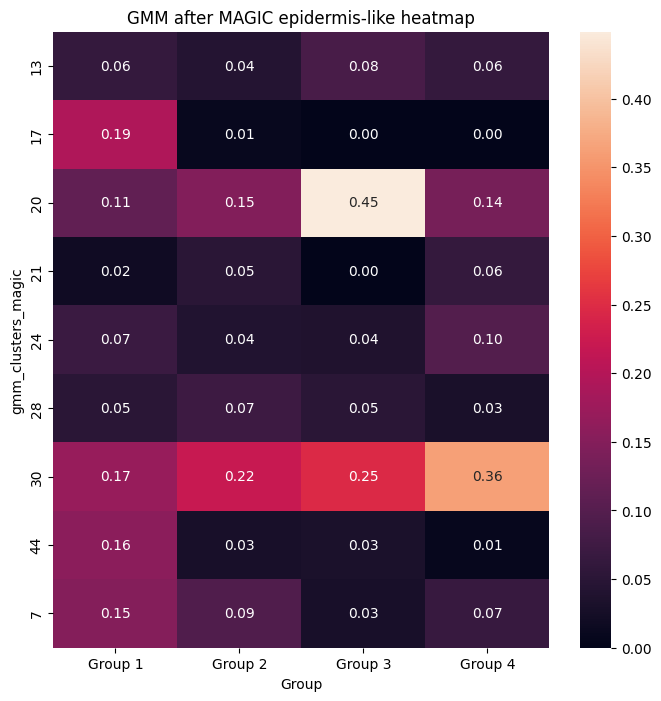

In [31]:
crosstab_group = pd.crosstab(
    adata_hvg_magic_epidermis.obs['gmm_clusters_magic'],
    adata_hvg_magic_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("GMM after MAGIC epidermis-like heatmap")
plt.show()

Cluster 44, 28

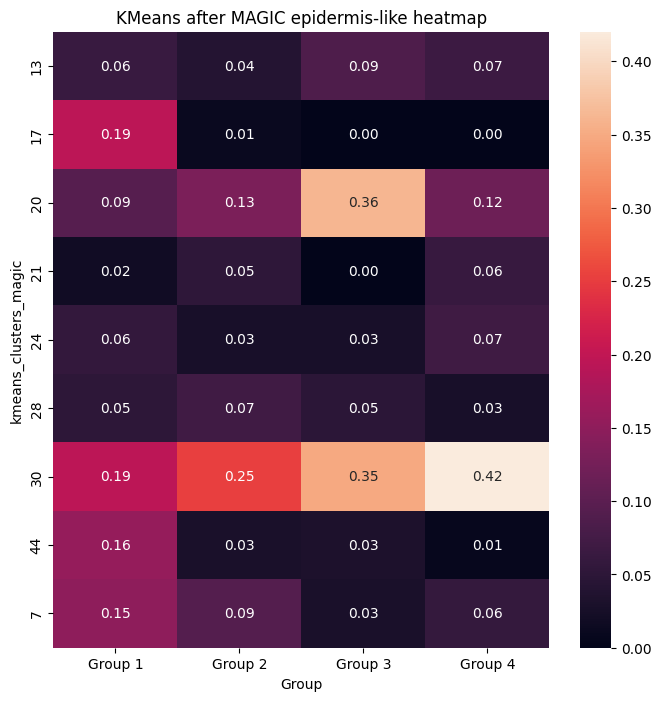

In [33]:
crosstab_group = pd.crosstab(
    adata_hvg_magic_epidermis.obs['kmeans_clusters_magic'],
    adata_hvg_magic_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("KMeans after MAGIC epidermis-like heatmap")
plt.show()

Cluster 28, 44

In [ ]:
# Reference
marker_logreg_magic_top_50 = {}
marker_wilcox_magic_top_50 = {}

clusters_to_id = ['ROCs']
adata_hvg_magic.obs['marker_id_target'] = 'Ignore'
adata_hvg_magic.obs.loc[adata_hvg_magic.obs['cluster'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_magic,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_magic, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'reference_logreg_MAGIC_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_magic_top_50['reference'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_magic,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_magic, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'reference_wilcox_MAGIC_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_magic_top_50['reference'] = marker_id_result_50

In [ ]:
# Leiden
clusters_to_id = ['20', '30']
adata_hvg_magic.obs['marker_id_target'] = 'Ignore'
adata_hvg_magic.obs.loc[adata_hvg_magic.obs['leiden_clusters_magic'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_magic,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_magic, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'leiden_logreg_MAGIC_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_magic_top_50['leiden'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_magic,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_magic, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'leiden_wilcox_MAGIC_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_magic_top_50['leiden'] = marker_id_result_50

In [ ]:
# GMM
clusters_to_id = ['44', '28']
adata_hvg_magic.obs['marker_id_target'] = 'Ignore'
adata_hvg_magic.obs.loc[adata_hvg_magic.obs['gmm_clusters_magic'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_magic,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_magic, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'gmm_logreg_MAGIC_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_magic_top_50['gmm'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_magic,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_magic, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'gmm_wilcox_MAGIC_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_magic_top_50['gmm'] = marker_id_result_50

In [ ]:
# Kmeans
clusters_to_id = ['28', '44']
adata_hvg_magic.obs['marker_id_target'] = 'Ignore'
adata_hvg_magic.obs.loc[adata_hvg_magic.obs['kmeans_clusters_magic'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_magic,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_magic, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'kmeans_logreg_MAGIC_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_magic_top_50['kmeans'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_magic,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_magic, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'kmeans_wilcox_MAGIC_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_magic_top_50['kmeans'] = marker_id_result_50

In [43]:
marker_mtx_colnames = list(marker_logreg_magic_top_50.keys())
marker_overlap_mtx_magic = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_logreg_magic_top_50[marker_mtx_colnames[i]]
        list2 = marker_logreg_magic_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx_magic.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx_magic

reference  leiden   gmm  kmeans
reference       50.0     2.0   5.0     5.0
leiden           2.0    50.0  14.0    12.0
gmm              5.0    14.0  50.0    40.0
kmeans           5.0    12.0  40.0    50.0

In [44]:
marker_mtx_colnames = list(marker_wilcox_magic_top_50.keys())
marker_overlap_mtx_magic = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_wilcox_magic_top_50[marker_mtx_colnames[i]]
        list2 = marker_wilcox_magic_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx_magic.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx_magic

reference  leiden   gmm  kmeans
reference       50.0     4.0   2.0     2.0
leiden           4.0    50.0  40.0    39.0
gmm              2.0    40.0  50.0    49.0
kmeans           2.0    39.0  49.0    50.0

We are further from reference than base version.

In [ ]:
table_3_list = pd.read_csv('table3_genes.csv', header=None).iloc[:, 0].tolist()
table_3_set = set(table_3_list)

marker_mtx_colnames = list(marker_wilcox_magic_top_50.keys())
marker_overlap_mtx_magic = pd.DataFrame(
    index=['vs. table3'],
    columns=list(marker_mtx_colnames),
    dtype=int
)

for colname in marker_mtx_colnames:
    list1 = marker_wilcox_magic_top_50[colname]
    list1_standardized = {gene.split('.')[0] for gene in list1}

    marker_overlap_mtx_val = len(
        list1_standardized.intersection(table_3_set)
    )
    marker_overlap_mtx_magic.loc['vs. table3', colname] = marker_overlap_mtx_val

marker_overlap_mtx_magic

reference  leiden  gmm  kmeans
vs. table3       19.0     5.0  5.0     5.0

Improvement on reference but nothing else

### KNN smoothing

In [48]:
# KNN pp1
hvg_connectivities_mat = adata_hvg.obsp['connectivities'].copy()
adata.obsp['hvg_distances'] = adata_hvg.obsp['distances'].copy()
hvg_conn_norm_mat = normalize(hvg_connectivities_mat, norm='l1', axis=1)

In [ ]:
# KNN pp2
adata.layers['knn_smooth'] = hvg_conn_norm_mat @ adata.X
sc.pp.highly_variable_genes(adata, layer='knn_smooth', n_top_genes=2300)
adata_hvg_knn = adata[:, adata.var.highly_variable].copy()
adata_hvg_knn.X = adata_hvg_knn.layers['knn_smooth'].copy()
sc.pp.scale(adata_hvg_knn, max_value=10)
sc.pp.pca(adata_hvg_knn, random_state=proj_rand_seed)

In [51]:
# KNN pp3
sc.pp.neighbors(
    adata_hvg_knn, 
    n_neighbors=15, 
    n_pcs=40,
    random_state=proj_rand_seed
)
target_cluster_count = adata_hvg_knn.obs['cluster'].nunique()
pca_embedding_knn = adata_hvg_knn.obsm['X_pca']
sc.tl.umap(adata_hvg_knn)

print(f'Reference column has {target_cluster_count:.0f} clusters')

Reference column has 46 clusters


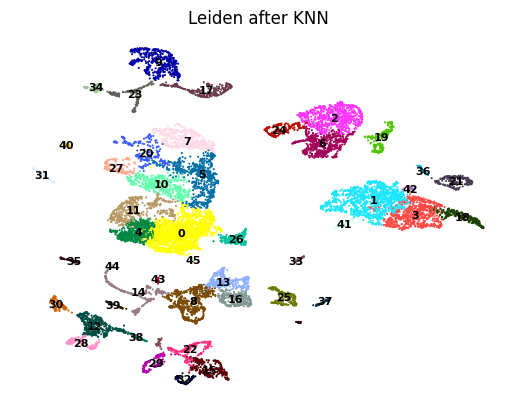

In [52]:
# KNN leiden 1
sc.tl.leiden(
    adata_hvg_knn, 
    resolution=0.96, 
    key_added='leiden_clusters_knn', 
    random_state=proj_rand_seed
)
sc.pl.umap(
    adata_hvg_knn,
    color='leiden_clusters_knn',
    title='Leiden after KNN',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_leiden_knn.png'
)

In [53]:
n_clusters_found = len(adata_hvg_knn.obs['leiden_clusters_knn'].unique())
n_clusters_found

46

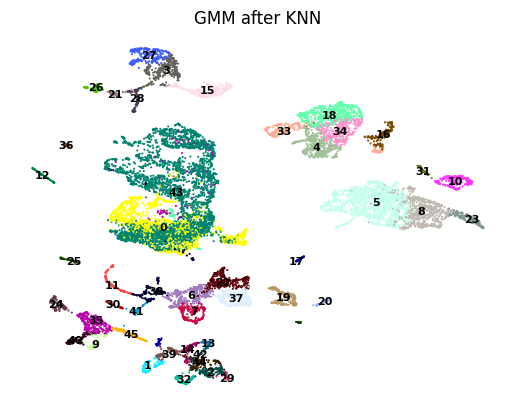

In [54]:
# KNN GMM 1
gmm_model = GaussianMixture(
    n_components=target_cluster_count,
    covariance_type='full',
    random_state=proj_rand_seed,
    reg_covar=1e-5
)
gmm_predictions_knn = gmm_model.fit_predict(pca_embedding_knn)
adata_hvg_knn.obs['gmm_clusters_knn'] = pd.Categorical(gmm_predictions_knn.astype(str))
sc.pl.umap(
    adata_hvg_knn,
    color='gmm_clusters_knn',
    title='GMM after KNN',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save="_gmm_knn.png"
)

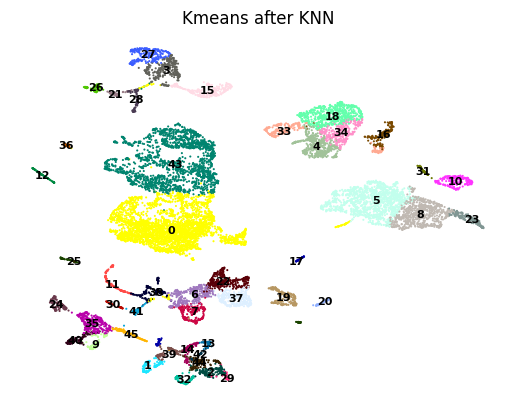

In [55]:
# KNN Kmeans 1
kmeans_model = KMeans(
    n_clusters=target_cluster_count,
    random_state=proj_rand_seed,
    n_init='auto'
)
kmeans_predictions_knn = kmeans_model.fit_predict(pca_embedding_knn)
adata_hvg_knn.obs['kmeans_clusters_knn'] = pd.Categorical(kmeans_predictions_knn.astype(str))

sc.pl.umap(
    adata_hvg_knn,
    color='kmeans_clusters_knn',
    title='Kmeans after KNN',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_k_means_knn.png'
)

In [56]:
cluster_metrics_knn = {}
cluster_metrics_knn['leiden'] = {}
cluster_metrics_knn['gmm'] = {}
cluster_metrics_knn['kmeans'] = {}

for method_name in cluster_metrics_knn.keys():
    temp_string = f'{method_name}_clusters_knn'
    cluster_metrics_knn[method_name]['silhouette'] = silhouette_score(
        pca_embedding_knn, 
        adata_hvg_knn.obs[temp_string]
    )
for method_name in cluster_metrics_knn.keys():
    temp_string = f'{method_name}_clusters_knn'
    cluster_metrics_knn[method_name]['davies_bouldin'] = davies_bouldin_score(
        pca_embedding_knn, 
        adata_hvg_knn.obs[temp_string]
    )
for method_name in cluster_metrics_knn.keys():
    temp_string = f'{method_name}_clusters_knn'
    cluster_metrics_knn[method_name]['calinski_harabasz'] = calinski_harabasz_score(
        pca_embedding_knn, 
        adata_hvg_knn.obs[temp_string]
    )

cluster_metrics_df_knn = pd.DataFrame(cluster_metrics_knn).T
cluster_metrics_df_knn

silhouette  davies_bouldin  calinski_harabasz
leiden    0.302198        1.114480        1811.044189
gmm       0.230841        0.949352        2555.378662
kmeans    0.438027        0.859256        3034.685547

Improvement on every metrics, more improvement than knn, reason?

In [57]:
condition_map = {
    "ST40_0": "Group 1",
    "ST40_1": "Group 2",
    "ST40_2": "Group 2",
    "ST40_3": "Group 2",
    "ST46_0": "Group 3",
    "ST46_1": "Group 4",
}
adata_hvg_knn.obs['Group'] = adata_hvg_knn.obs['Condition'].map(condition_map)

In [58]:
gene_list = adata.var_names
sc.tl.rank_genes_groups(
    adata_hvg_knn, 
    groupby="cluster", 
    groups=['Epidermis', 'laminin-rich epidermis'], 
    method='t-test',
    key_added="cluster_ttest_rank",
    n_genes=50
)
epidermis_markers_knn_df = pd.DataFrame(adata_hvg_knn.uns['cluster_ttest_rank']['names'])[['Epidermis', 'laminin-rich epidermis']]
epidermis_markers_knn_df
# Put two columns together
epidermis_markers_epidermis = epidermis_markers_knn_df['Epidermis'].head(50).tolist()
epidermis_markers_laminin = epidermis_markers_knn_df['laminin-rich epidermis'].head(50).tolist()
epidermis_markers_knn = list(set(epidermis_markers_epidermis + epidermis_markers_laminin))

In [59]:
sc.tl.score_genes(
    adata_hvg_knn,
    gene_list = epidermis_markers_knn,
    score_name = 'epidermis_score',
    use_raw = True
)

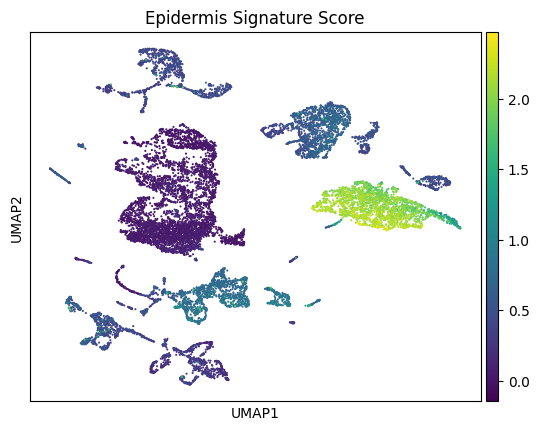

In [60]:
sc.pl.umap(
    adata_hvg_knn,
    color='epidermis_score',
    title='Epidermis Signature Score'
)

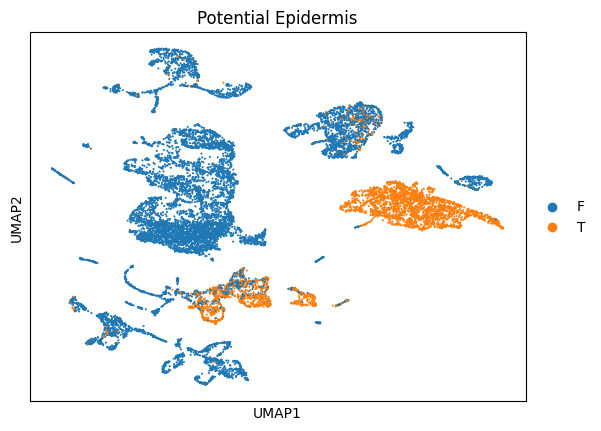

In [61]:
epidermis_high_expression = adata_hvg_knn.obs['epidermis_score'] > adata_hvg_knn.obs['epidermis_score'].quantile(0.75)
adata_hvg_knn.obs['epidermis_like'] = np.where(epidermis_high_expression, "T", "F")
sc.pl.umap(
    adata_hvg_knn,
    color='epidermis_like',
    title='Potential Epidermis'
)

In [62]:
adata_hvg_knn_epidermis = adata_hvg_knn[epidermis_high_expression, :].copy()

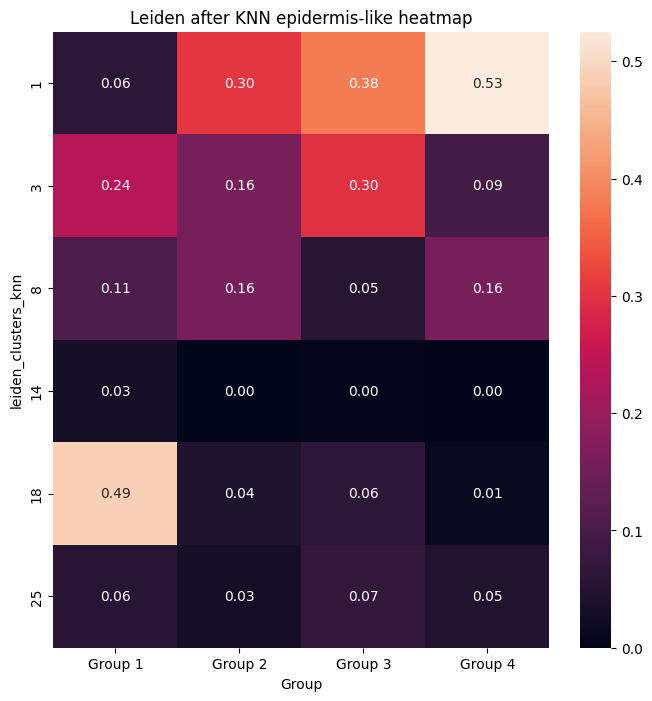

In [63]:
crosstab_group = pd.crosstab(
    adata_hvg_knn_epidermis.obs['leiden_clusters_knn'],
    adata_hvg_knn_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("Leiden after KNN epidermis-like heatmap")
plt.show()

Cluster 18, 3

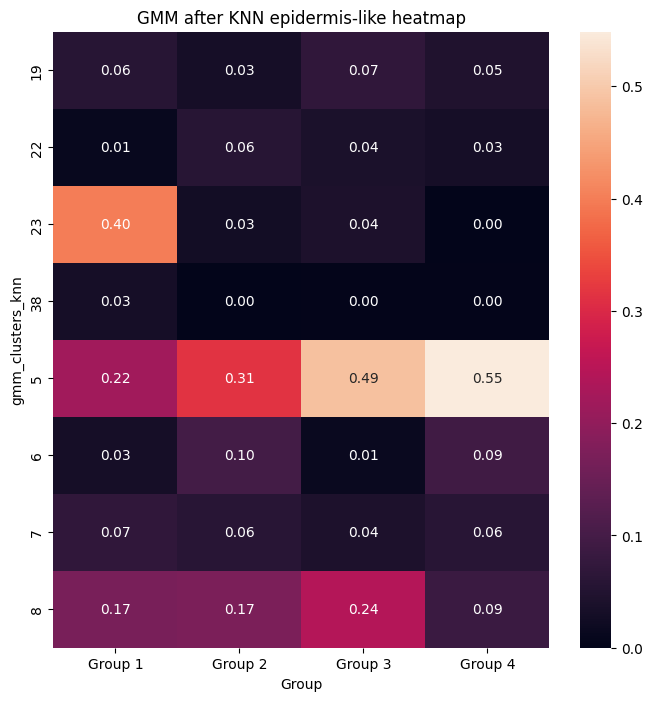

In [64]:
crosstab_group = pd.crosstab(
    adata_hvg_knn_epidermis.obs['gmm_clusters_knn'],
    adata_hvg_knn_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("GMM after KNN epidermis-like heatmap")
plt.show()

Cluster 8, 23

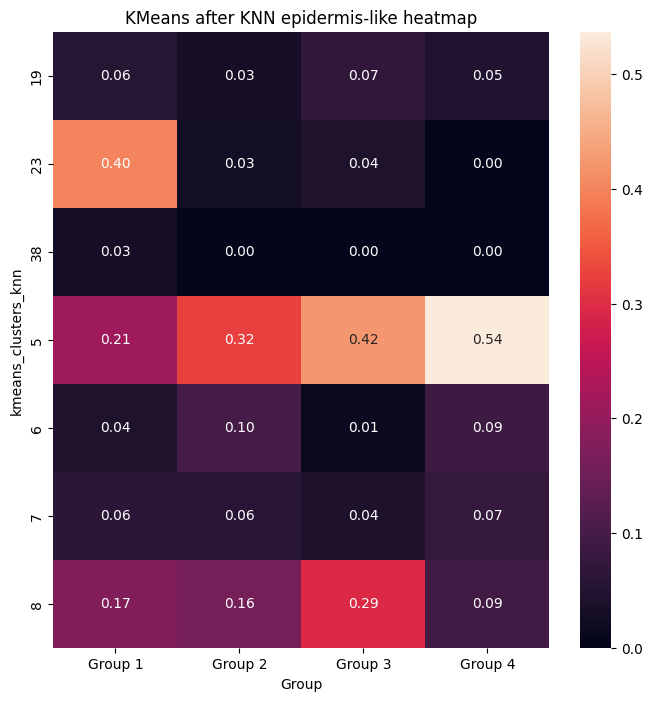

In [65]:
crosstab_group = pd.crosstab(
    adata_hvg_knn_epidermis.obs['kmeans_clusters_knn'],
    adata_hvg_knn_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("KMeans after KNN epidermis-like heatmap")
plt.show()

Cluster 8, 23

In [ ]:
# Reference
marker_logreg_knn_top_50 = {}
marker_wilcox_knn_top_50 = {}

clusters_to_id = ['ROCs']
adata_hvg_knn.obs['marker_id_target'] = 'Ignore'
adata_hvg_knn.obs.loc[adata_hvg_knn.obs['cluster'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_knn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_knn, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'reference_logreg_KNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_knn_top_50['reference'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_knn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_knn, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'reference_wilcox_KNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_knn_top_50['reference'] = marker_id_result_50

In [ ]:
# Leiden
clusters_to_id = ['18', '3']
adata_hvg_knn.obs['marker_id_target'] = 'Ignore'
adata_hvg_knn.obs.loc[adata_hvg_knn.obs['leiden_clusters_knn'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_knn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_knn, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'leiden_logreg_KNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_knn_top_50['leiden'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_knn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_knn, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'leiden_wilcox_KNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_knn_top_50['leiden'] = marker_id_result_50

In [ ]:
# GMM
clusters_to_id = ['8', '23']
adata_hvg_knn.obs['marker_id_target'] = 'Ignore'
adata_hvg_knn.obs.loc[adata_hvg_knn.obs['gmm_clusters_knn'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_knn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_knn, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'gmm_logreg_KNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_knn_top_50['gmm'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_knn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_knn, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'gmm_wilcox_KNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_knn_top_50['gmm'] = marker_id_result_50

In [ ]:
# Kmeans
clusters_to_id = ['8', '23']
adata_hvg_knn.obs['marker_id_target'] = 'Ignore'
adata_hvg_knn.obs.loc[adata_hvg_knn.obs['kmeans_clusters_knn'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_knn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_knn, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'kmeans_logreg_KNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_knn_top_50['kmeans'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_knn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_knn, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'kmeans_wilcox_KNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_knn_top_50['kmeans'] = marker_id_result_50

In [71]:
# bench - logreg
marker_mtx_colnames = list(marker_logreg_knn_top_50.keys())
marker_overlap_mtx_knn = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_logreg_knn_top_50[marker_mtx_colnames[i]]
        list2 = marker_logreg_knn_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx_knn.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx_knn

reference  leiden   gmm  kmeans
reference       50.0    19.0  16.0    16.0
leiden          19.0    50.0  27.0    36.0
gmm             16.0    27.0  50.0    29.0
kmeans          16.0    36.0  29.0    50.0

In [72]:
# bench - wilcox
marker_mtx_colnames = list(marker_wilcox_knn_top_50.keys())
marker_overlap_mtx_knn = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_wilcox_knn_top_50[marker_mtx_colnames[i]]
        list2 = marker_wilcox_knn_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx_knn.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx_knn

reference  leiden   gmm  kmeans
reference       50.0    21.0  25.0    22.0
leiden          21.0    50.0  44.0    47.0
gmm             25.0    44.0  50.0    47.0
kmeans          22.0    47.0  47.0    50.0

Great

In [73]:
table_3_list = pd.read_csv('table3_genes.csv', header=None).iloc[:, 0].tolist()
table_3_set = set(table_3_list)

marker_mtx_colnames = list(marker_wilcox_knn_top_50.keys())
marker_overlap_mtx_knn = pd.DataFrame(
    index=['vs. table3'],
    columns=list(marker_mtx_colnames),
    dtype=int
)

for colname in marker_mtx_colnames:
    list1 = marker_wilcox_knn_top_50[colname]
    list1_standardized = {gene.split('.')[0] for gene in list1}

    marker_overlap_mtx_val = len(
        list1_standardized.intersection(table_3_set)
    )
    marker_overlap_mtx_knn.loc['vs. table3', colname] = marker_overlap_mtx_val

marker_overlap_mtx_knn

reference  leiden   gmm  kmeans
vs. table3       18.0     8.0  10.0     9.0

Still not great, tb3 is confusing

## Batch Intergration

In [ ]:
adata = sc.read_h5ad(path_h5ad_used)
adata.X.todense()

adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2300)

adata_hvg = adata[:, adata.var.highly_variable]
sc.pp.scale(adata_hvg, max_value=10)
sc.pp.pca(adata_hvg, n_comps=50)

sc.pp.neighbors(
    adata_hvg,
    n_neighbors=15,
    n_pcs=40,
    random_state=proj_rand_seed
)
sc.tl.umap(adata_hvg)

It's the same procedure as before the baseline clustering

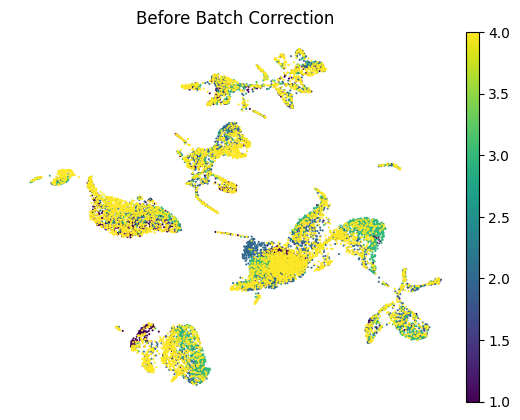

In [12]:
sc.pl.umap(adata_hvg, color='batch', title='Before Batch Correction', frameon=False)

### Harmony

In [74]:
# Harmony 1
adata_hvg_harmony = adata_hvg.copy()
adata_hvg_harmony.obs['batch'] = adata_hvg_harmony.obs['batch'].astype(str)
sce.pp.harmony_integrate(
    adata_hvg_harmony,
    key='batch',
    basis='X_pca',
    adjusted_basis='X_pca_harmony',
    random_state=proj_rand_seed
)

2025-10-16 17:32:28,898 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-16 17:32:30,948 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-16 17:32:31,055 - harmonypy - INFO - Iteration 1 of 10
2025-10-16 17:32:34,584 - harmonypy - INFO - Iteration 2 of 10
2025-10-16 17:32:38,407 - harmonypy - INFO - Iteration 3 of 10
2025-10-16 17:32:41,915 - harmonypy - INFO - Iteration 4 of 10
2025-10-16 17:32:45,354 - harmonypy - INFO - Iteration 5 of 10
2025-10-16 17:32:49,032 - harmonypy - INFO - Converged after 5 iterations


In [75]:
# Harmony 2
sc.pp.neighbors(
    adata_hvg_harmony, 
    n_neighbors=15,
    n_pcs=40, 
    use_rep='X_pca_harmony',
    random_state=proj_rand_seed
)
pca_embedding_harmony = adata_hvg_harmony.obsm['X_pca']
sc.tl.umap(adata_hvg_harmony)

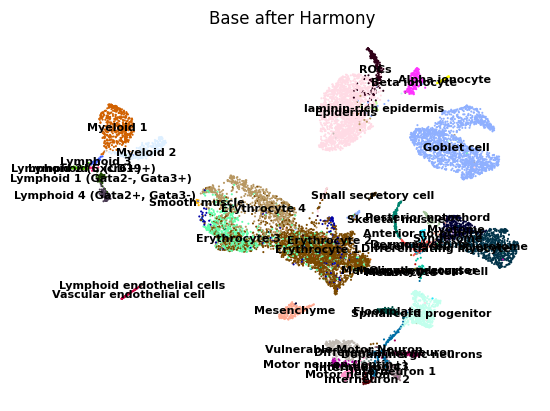

In [76]:
# Harmony 3
sc.pl.umap(
    adata_hvg_harmony,
    color='cluster',
    title='Base after Harmony',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8
)

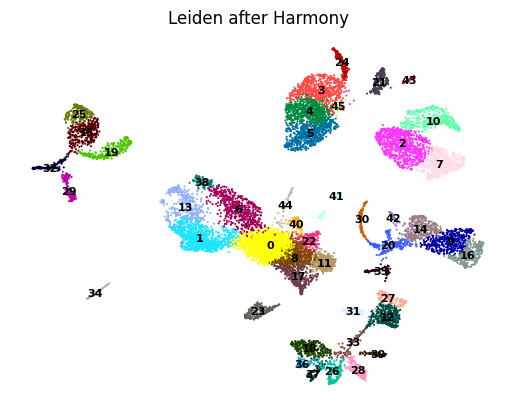

In [77]:
# Harmony leiden 1
sc.tl.leiden(
    adata_hvg_harmony, 
    resolution=2.34, 
    key_added='leiden_clusters_harmony', 
    random_state=proj_rand_seed
)
sc.pl.umap(
    adata_hvg_harmony,
    color='leiden_clusters_harmony',
    title='Leiden after Harmony',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_leiden_harmony.png'
)

In [78]:
n_clusters_found = len(adata_hvg_harmony.obs['leiden_clusters_harmony'].unique())
target_cluster_count = n_clusters_found
n_clusters_found

46

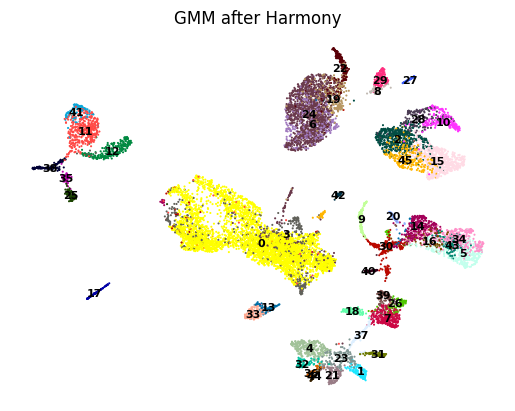

In [79]:
# Harmony GMM 1
gmm_model = GaussianMixture(
    n_components=target_cluster_count,
    covariance_type='full',
    random_state=proj_rand_seed,
    reg_covar=1e-5
)
gmm_predictions_harmony = gmm_model.fit_predict(pca_embedding_harmony)
adata_hvg_harmony.obs['gmm_clusters_harmony'] = pd.Categorical(gmm_predictions_harmony.astype(str))
sc.pl.umap(
    adata_hvg_harmony,
    color='gmm_clusters_harmony',
    title='GMM after Harmony',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save="_gmm_harmony.png"
)

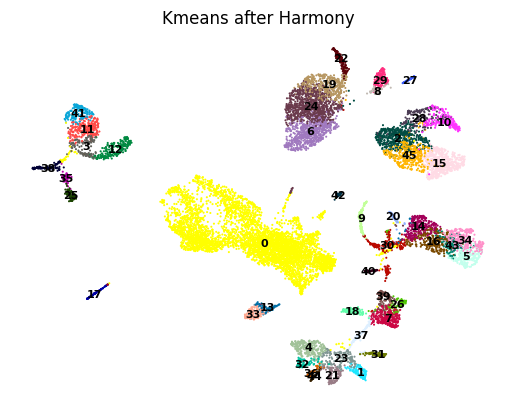

In [80]:
# Harmony Kmeans 1
kmeans_model = KMeans(
    n_clusters=target_cluster_count,
    random_state=proj_rand_seed,
    n_init='auto'
)
kmeans_predictions_harmony = kmeans_model.fit_predict(pca_embedding_harmony)
adata_hvg_harmony.obs['kmeans_clusters_harmony'] = pd.Categorical(kmeans_predictions_harmony.astype(str))

sc.pl.umap(
    adata_hvg_harmony,
    color='kmeans_clusters_harmony',
    title='Kmeans after Harmony',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_k_means_harmony.png'
)

In [81]:
cluster_metrics_harmony = {}
cluster_metrics_harmony['leiden'] = {}
cluster_metrics_harmony['gmm'] = {}
cluster_metrics_harmony['kmeans'] = {}

for method_name in cluster_metrics_harmony.keys():
    temp_string = f'{method_name}_clusters_harmony'
    cluster_metrics_harmony[method_name]['silhouette'] = silhouette_score(
        pca_embedding_harmony, 
        adata_hvg_harmony.obs[temp_string]
    )
for method_name in cluster_metrics_harmony.keys():
    temp_string = f'{method_name}_clusters_harmony'
    cluster_metrics_harmony[method_name]['davies_bouldin'] = davies_bouldin_score(
        pca_embedding_harmony, 
        adata_hvg_harmony.obs[temp_string]
    )
for method_name in cluster_metrics_harmony.keys():
    temp_string = f'{method_name}_clusters_harmony'
    cluster_metrics_harmony[method_name]['calinski_harabasz'] = calinski_harabasz_score(
        pca_embedding_harmony, 
        adata_hvg_harmony.obs[temp_string]
    )

cluster_metrics_df_harmony = pd.DataFrame(cluster_metrics_harmony).T
cluster_metrics_df_harmony

silhouette  davies_bouldin  calinski_harabasz
leiden    0.202382        1.415607        1481.996216
gmm       0.214750        1.525976        1510.567871
kmeans    0.448316        1.161730        1899.726196

In [82]:
condition_map = {
    "ST40_0": "Group 1",
    "ST40_1": "Group 2",
    "ST40_2": "Group 2",
    "ST40_3": "Group 2",
    "ST46_0": "Group 3",
    "ST46_1": "Group 4",
}
adata_hvg_harmony.obs['Group'] = adata_hvg_harmony.obs['Condition'].map(condition_map)

In [83]:
gene_list = adata.var_names
sc.tl.rank_genes_groups(
    adata_hvg_harmony, 
    groupby="cluster", 
    groups=['Epidermis', 'laminin-rich epidermis'], 
    method='t-test',
    key_added="cluster_ttest_rank",
    n_genes=50
)
epidermis_markers_harmony_df = pd.DataFrame(adata_hvg_harmony.uns['cluster_ttest_rank']['names'])[['Epidermis', 'laminin-rich epidermis']]
epidermis_markers_harmony_df
# Put two columns together
epidermis_markers_epidermis = epidermis_markers_harmony_df['Epidermis'].head(50).tolist()
epidermis_markers_laminin = epidermis_markers_harmony_df['laminin-rich epidermis'].head(50).tolist()
epidermis_markers_harmony = list(set(epidermis_markers_epidermis + epidermis_markers_laminin))

In [84]:
sc.tl.score_genes(
    adata_hvg_harmony,
    gene_list = epidermis_markers_harmony,
    score_name = 'epidermis_score',
    use_raw = True
)

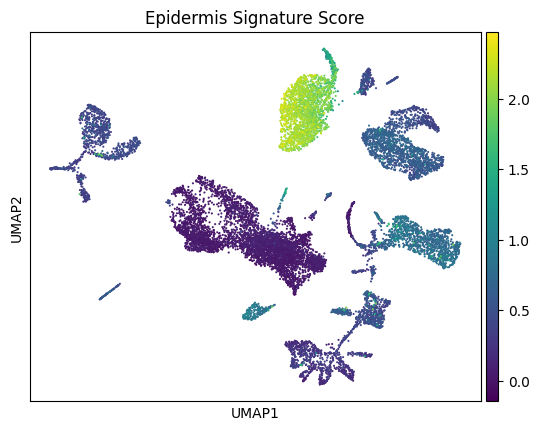

In [85]:
sc.pl.umap(
    adata_hvg_harmony,
    color='epidermis_score',
    title='Epidermis Signature Score'
)

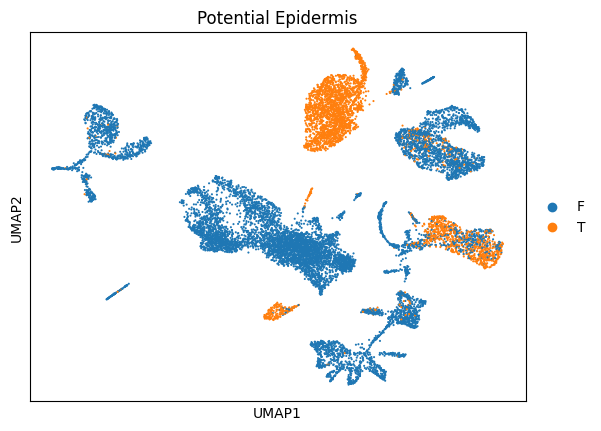

In [86]:
epidermis_high_expression = adata_hvg_harmony.obs['epidermis_score'] > adata_hvg_harmony.obs['epidermis_score'].quantile(0.75)
adata_hvg_harmony.obs['epidermis_like'] = np.where(epidermis_high_expression, "T", "F")
sc.pl.umap(
    adata_hvg_harmony,
    color='epidermis_like',
    title='Potential Epidermis'
)

In [87]:
adata_hvg_harmony_epidermis = adata_hvg_harmony[epidermis_high_expression, :].copy()

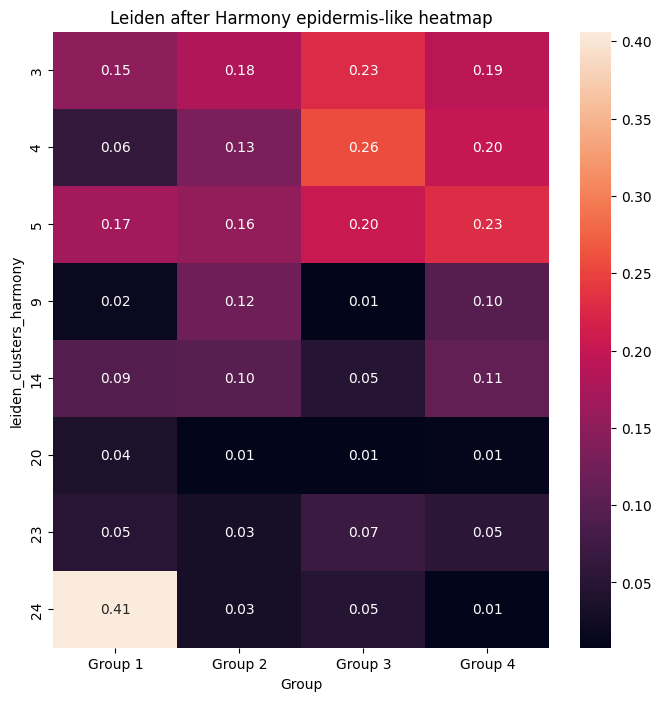

In [88]:
crosstab_group = pd.crosstab(
    adata_hvg_harmony_epidermis.obs['leiden_clusters_harmony'],
    adata_hvg_harmony_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("Leiden after Harmony epidermis-like heatmap")
plt.show()

Cluster 24

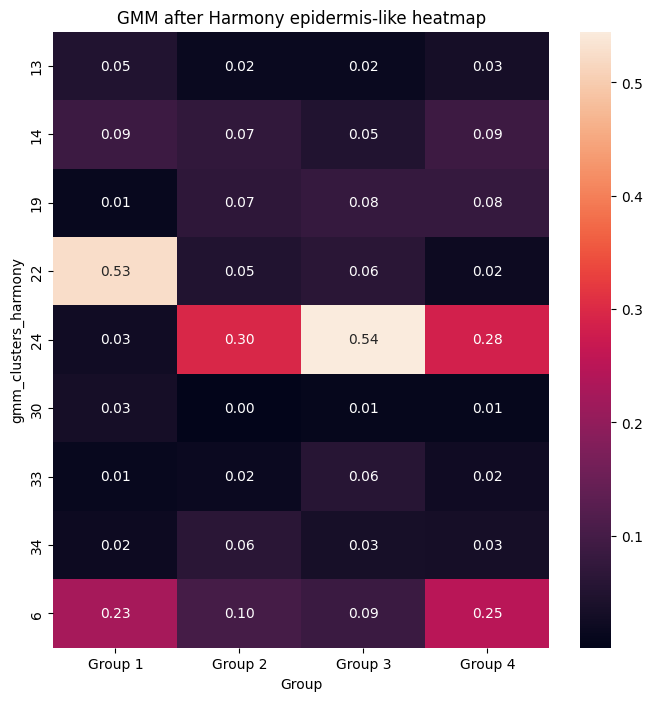

In [89]:
crosstab_group = pd.crosstab(
    adata_hvg_harmony_epidermis.obs['gmm_clusters_harmony'],
    adata_hvg_harmony_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("GMM after Harmony epidermis-like heatmap")
plt.show()

Cluster 22

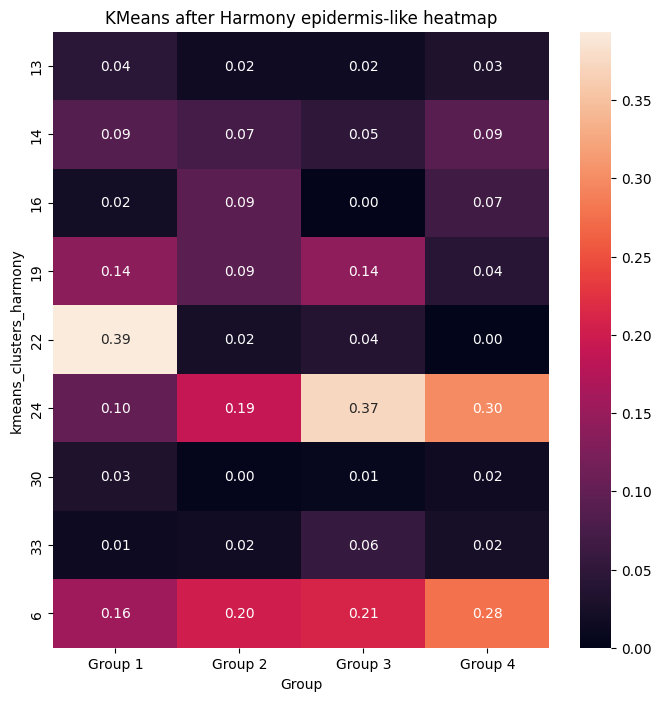

In [91]:
crosstab_group = pd.crosstab(
    adata_hvg_harmony_epidermis.obs['kmeans_clusters_harmony'],
    adata_hvg_harmony_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("KMeans after Harmony epidermis-like heatmap")
plt.show()

Cluster 22, 19

In [ ]:
# Reference
marker_logreg_harmony_top_50 = {}
marker_wilcox_harmony_top_50 = {}

clusters_to_id = ['ROCs']
adata_hvg_harmony.obs['marker_id_target'] = 'Ignore'
adata_hvg_harmony.obs.loc[adata_hvg_harmony.obs['cluster'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_harmony,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_harmony, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'reference_logreg_Harmony_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_harmony_top_50['reference'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_harmony,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_harmony, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'reference_wilcox_Harmony_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_harmony_top_50['reference'] = marker_id_result_50

In [ ]:
# Leiden
clusters_to_id = ['24']
adata_hvg_harmony.obs['marker_id_target'] = 'Ignore'
adata_hvg_harmony.obs.loc[adata_hvg_harmony.obs['leiden_clusters_harmony'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_harmony,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_harmony, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'leiden_logreg_Harmony_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_harmony_top_50['leiden'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_harmony,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_harmony, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'leiden_wilcox_Harmony_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_harmony_top_50['leiden'] = marker_id_result_50

In [ ]:
# GMM
clusters_to_id = ['22']
adata_hvg_harmony.obs['marker_id_target'] = 'Ignore'
adata_hvg_harmony.obs.loc[adata_hvg_harmony.obs['gmm_clusters_harmony'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_harmony,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_harmony, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'gmm_logreg_Harmony_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_harmony_top_50['gmm'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_harmony,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_harmony, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'gmm_wilcox_Harmony_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_harmony_top_50['gmm'] = marker_id_result_50

In [ ]:
# Kmeans
clusters_to_id = ['22', '19']
adata_hvg_harmony.obs['marker_id_target'] = 'Ignore'
adata_hvg_harmony.obs.loc[adata_hvg_harmony.obs['kmeans_clusters_harmony'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_harmony,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_harmony, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'kmeans_logreg_Harmony_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_harmony_top_50['kmeans'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_harmony,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_harmony, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'kmeans_wilcox_Harmony_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_harmony_top_50['kmeans'] = marker_id_result_50

In [96]:
marker_mtx_colnames = list(marker_logreg_harmony_top_50.keys())
marker_overlap_mtx_harmony = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_logreg_harmony_top_50[marker_mtx_colnames[i]]
        list2 = marker_logreg_harmony_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx_harmony.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx_harmony

reference  leiden   gmm  kmeans
reference       50.0    31.0  26.0    22.0
leiden          31.0    50.0  28.0    30.0
gmm             26.0    28.0  50.0    24.0
kmeans          22.0    30.0  24.0    50.0

In [97]:
marker_mtx_colnames = list(marker_wilcox_harmony_top_50.keys())
marker_overlap_mtx_harmony = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_wilcox_harmony_top_50[marker_mtx_colnames[i]]
        list2 = marker_wilcox_harmony_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx_harmony.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx_harmony

reference  leiden   gmm  kmeans
reference       50.0    44.0  50.0    36.0
leiden          44.0    50.0  44.0    30.0
gmm             50.0    44.0  50.0    36.0
kmeans          36.0    30.0  36.0    50.0

Good

In [98]:
table_3_list = pd.read_csv('table3_genes.csv', header=None).iloc[:, 0].tolist()
table_3_set = set(table_3_list)

marker_mtx_colnames = list(marker_wilcox_harmony_top_50.keys())
marker_overlap_mtx_harmony = pd.DataFrame(
    index=['vs. table3'],
    columns=list(marker_mtx_colnames),
    dtype=int
)

for colname in marker_mtx_colnames:
    list1 = marker_wilcox_harmony_top_50[colname]
    list1_standardized = {gene.split('.')[0] for gene in list1}

    marker_overlap_mtx_val = len(
        list1_standardized.intersection(table_3_set)
    )
    marker_overlap_mtx_harmony.loc['vs. table3', colname] = marker_overlap_mtx_val

marker_overlap_mtx_harmony

reference  leiden  gmm  kmeans
vs. table3        7.0    11.0  7.0     2.0

Emmm..

### BBKNN

In [99]:
# BBKNN 1
adata_hvg_bbknn = adata_hvg.copy()
adata_hvg_bbknn.obs['batch'] = adata_hvg_bbknn.obs['batch'].astype(str)
bbknn.bbknn(
    adata_hvg_bbknn,
    batch_key = 'batch',
    n_pcs=40
)
pca_embedding_bbknn = adata_hvg_bbknn.obsm['X_pca']
sc.tl.umap(adata_hvg_bbknn)

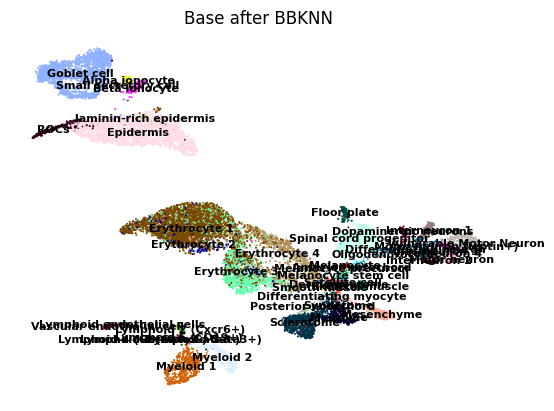

In [100]:
# BBKNN 2
sc.pl.umap(
    adata_hvg_bbknn,
    color='cluster',
    title='Base after BBKNN',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8
)

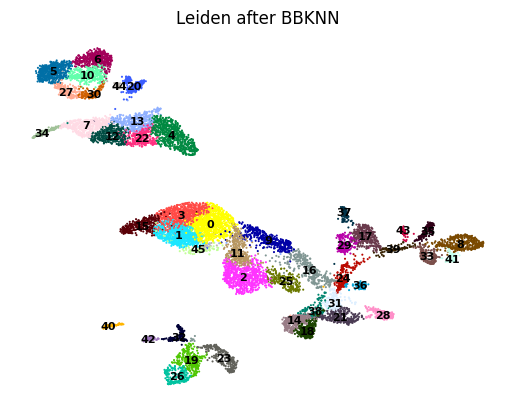

In [101]:
# BBKNN leiden 1
sc.tl.leiden(
    adata_hvg_bbknn, 
    resolution=3.46, 
    key_added='leiden_clusters_bbknn', 
    random_state=proj_rand_seed
)
sc.pl.umap(
    adata_hvg_bbknn,
    color='leiden_clusters_bbknn',
    title='Leiden after BBKNN',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_leiden_bbknn.png'
)

In [102]:
n_clusters_found = len(adata_hvg_bbknn.obs['leiden_clusters_bbknn'].unique())
target_cluster_count = n_clusters_found
n_clusters_found

46

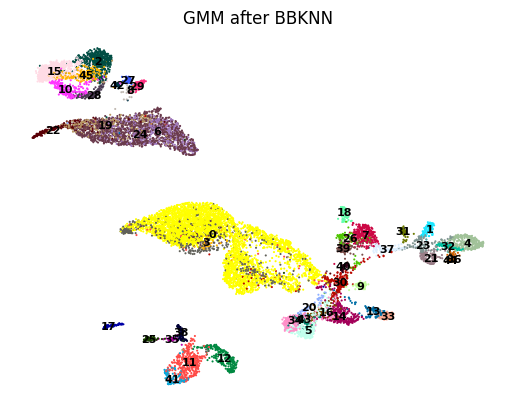

In [103]:
# BBKNN GMM 1
gmm_model = GaussianMixture(
    n_components=target_cluster_count,
    covariance_type='full',
    random_state=proj_rand_seed,
    reg_covar=1e-5
)
gmm_predictions_bbknn = gmm_model.fit_predict(pca_embedding_bbknn)
adata_hvg_bbknn.obs['gmm_clusters_bbknn'] = pd.Categorical(gmm_predictions_bbknn.astype(str))
sc.pl.umap(
    adata_hvg_bbknn,
    color='gmm_clusters_bbknn',
    title='GMM after BBKNN',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save="_gmm_bbknn.png"
)

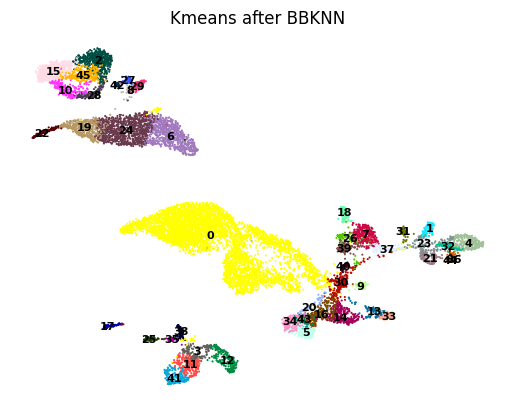

In [104]:
# BBKNN Kmeans 1
kmeans_model = KMeans(
    n_clusters=target_cluster_count,
    random_state=proj_rand_seed,
    n_init='auto'
)
kmeans_predictions_bbknn = kmeans_model.fit_predict(pca_embedding_bbknn)
adata_hvg_bbknn.obs['kmeans_clusters_bbknn'] = pd.Categorical(kmeans_predictions_bbknn.astype(str))

sc.pl.umap(
    adata_hvg_bbknn,
    color='kmeans_clusters_bbknn',
    title='Kmeans after BBKNN',
    frameon=False,
    legend_loc='on data',
    legend_fontsize=8,
    save='_k_means_bbknn.png'
)

In [105]:
cluster_metrics_bbknn = {}
cluster_metrics_bbknn['leiden'] = {}
cluster_metrics_bbknn['gmm'] = {}
cluster_metrics_bbknn['kmeans'] = {}

for method_name in cluster_metrics_bbknn.keys():
    temp_string = f'{method_name}_clusters_bbknn'
    cluster_metrics_bbknn[method_name]['silhouette'] = silhouette_score(
        pca_embedding_bbknn, 
        adata_hvg_bbknn.obs[temp_string]
    )
for method_name in cluster_metrics_bbknn.keys():
    temp_string = f'{method_name}_clusters_bbknn'
    cluster_metrics_bbknn[method_name]['davies_bouldin'] = davies_bouldin_score(
        pca_embedding_bbknn, 
        adata_hvg_bbknn.obs[temp_string]
    )
for method_name in cluster_metrics_bbknn.keys():
    temp_string = f'{method_name}_clusters_bbknn'
    cluster_metrics_bbknn[method_name]['calinski_harabasz'] = calinski_harabasz_score(
        pca_embedding_bbknn, 
        adata_hvg_bbknn.obs[temp_string]
    )

cluster_metrics_df_bbknn = pd.DataFrame(cluster_metrics_bbknn).T
cluster_metrics_df_bbknn

silhouette  davies_bouldin  calinski_harabasz
leiden    0.166172        1.534993        1362.224365
gmm       0.214750        1.525976        1510.567871
kmeans    0.448316        1.161730        1899.726196

Apparently BBKNN does not affect gmm and kmeans, and for the benchmark used here,

it made leiden worse (other benchmarks?)

In [106]:
condition_map = {
    "ST40_0": "Group 1",
    "ST40_1": "Group 2",
    "ST40_2": "Group 2",
    "ST40_3": "Group 2",
    "ST46_0": "Group 3",
    "ST46_1": "Group 4",
}
adata_hvg_bbknn.obs['Group'] = adata_hvg_bbknn.obs['Condition'].map(condition_map)

In [107]:
gene_list = adata.var_names
sc.tl.rank_genes_groups(
    adata_hvg_bbknn, 
    groupby="cluster", 
    groups=['Epidermis', 'laminin-rich epidermis'], 
    method='t-test',
    key_added="cluster_ttest_rank",
    n_genes=50
)
epidermis_markers_bbknn_df = pd.DataFrame(adata_hvg_bbknn.uns['cluster_ttest_rank']['names'])[['Epidermis', 'laminin-rich epidermis']]
epidermis_markers_bbknn_df
# Put two columns together
epidermis_markers_epidermis = epidermis_markers_bbknn_df['Epidermis'].head(50).tolist()
epidermis_markers_laminin = epidermis_markers_bbknn_df['laminin-rich epidermis'].head(50).tolist()
epidermis_markers_bbknn = list(set(epidermis_markers_epidermis + epidermis_markers_laminin))

In [108]:
sc.tl.score_genes(
    adata_hvg_bbknn,
    gene_list = epidermis_markers_bbknn,
    score_name = 'epidermis_score',
    use_raw = True
)

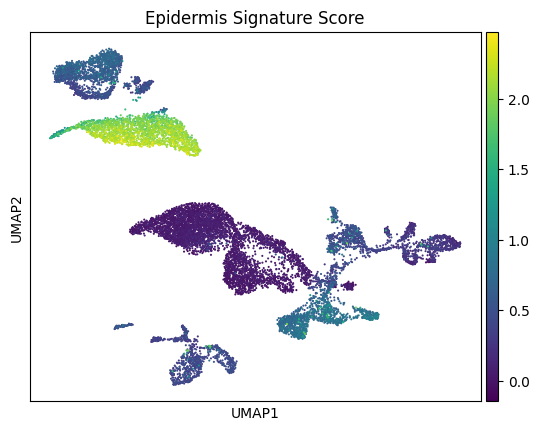

In [109]:
sc.pl.umap(
    adata_hvg_bbknn,
    color='epidermis_score',
    title='Epidermis Signature Score'
)

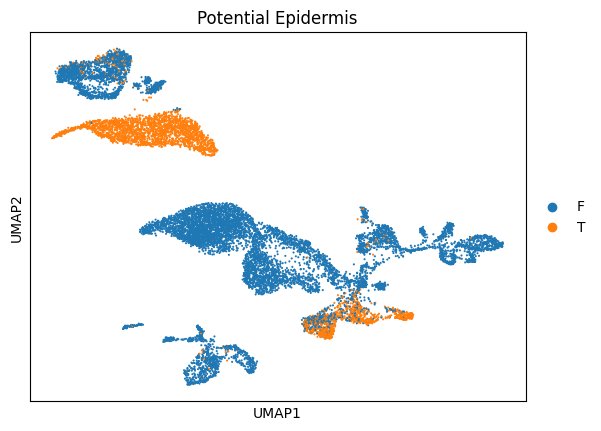

In [110]:
epidermis_high_expression = adata_hvg_bbknn.obs['epidermis_score'] > adata_hvg_bbknn.obs['epidermis_score'].quantile(0.75)
adata_hvg_bbknn.obs['epidermis_like'] = np.where(epidermis_high_expression, "T", "F")
sc.pl.umap(
    adata_hvg_bbknn,
    color='epidermis_like',
    title='Potential Epidermis'
)

In [111]:
adata_hvg_bbknn_epidermis = adata_hvg_bbknn[epidermis_high_expression, :].copy()

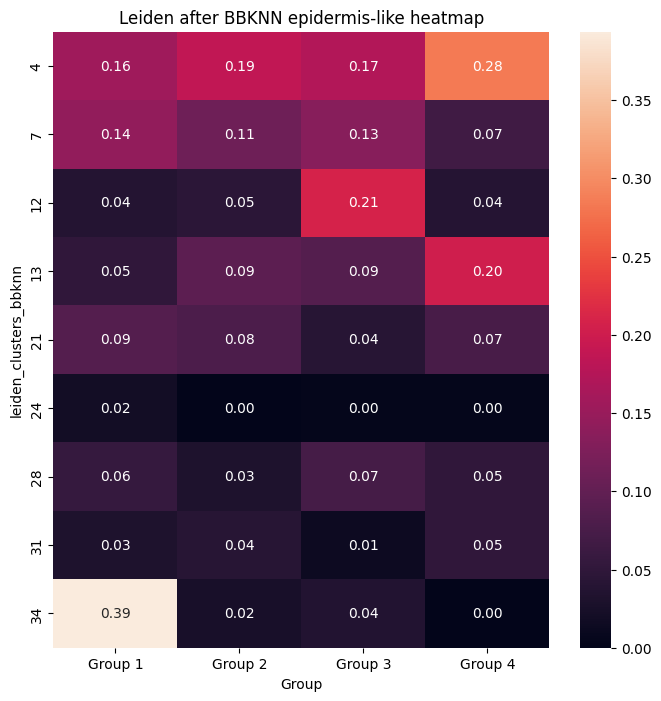

In [112]:
crosstab_group = pd.crosstab(
    adata_hvg_bbknn_epidermis.obs['leiden_clusters_bbknn'],
    adata_hvg_bbknn_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("Leiden after BBKNN epidermis-like heatmap")
plt.show()

Cluster 34, 7

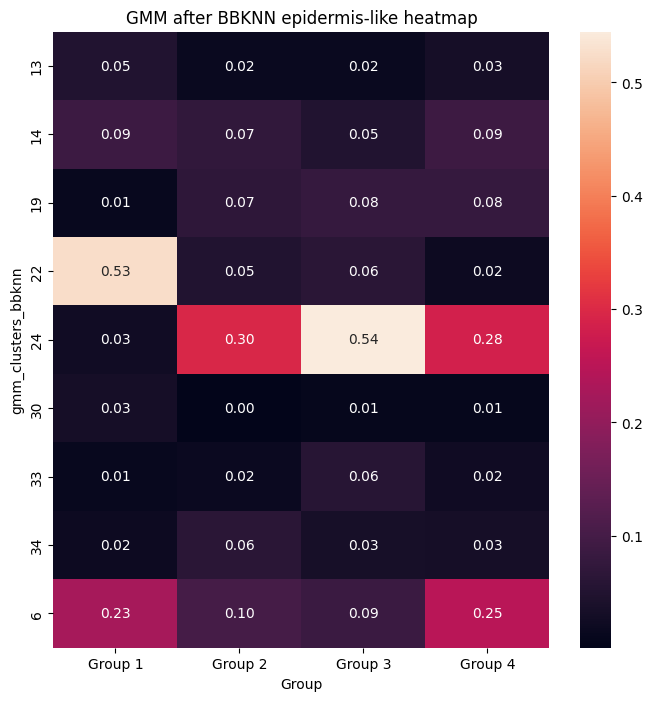

In [113]:
crosstab_group = pd.crosstab(
    adata_hvg_bbknn_epidermis.obs['gmm_clusters_bbknn'],
    adata_hvg_bbknn_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("GMM after BBKNN epidermis-like heatmap")
plt.show()

Cluster 22

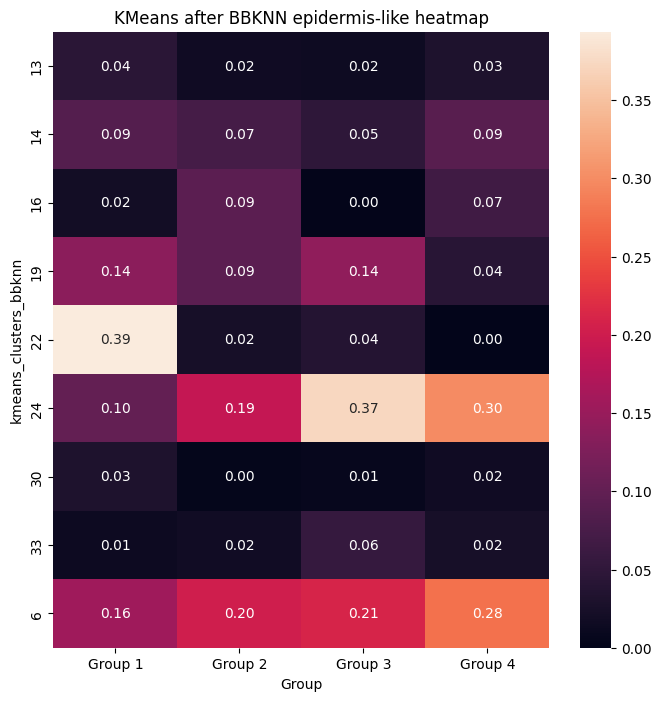

In [114]:
crosstab_group = pd.crosstab(
    adata_hvg_bbknn_epidermis.obs['kmeans_clusters_bbknn'],
    adata_hvg_bbknn_epidermis.obs['Group']
)
crosstab_group_prop = crosstab_group.div(crosstab_group.sum(axis=0), axis=1)
crosstab_filter_condition = crosstab_group_prop['Group 1'] > 0.01
crosstab_filtered_prop = crosstab_group_prop[crosstab_filter_condition]

plt.figure(figsize=(8,8))
sns.heatmap(
    crosstab_filtered_prop,
    annot=True, # Show values
    fmt=".2f"
)
plt.title("KMeans after BBKNN epidermis-like heatmap")
plt.show()

Cluster 22, 19

In [ ]:
# Reference
marker_logreg_bbknn_top_50 = {}
marker_wilcox_bbknn_top_50 = {}

clusters_to_id = ['ROCs']
adata_hvg_bbknn.obs['marker_id_target'] = 'Ignore'
adata_hvg_bbknn.obs.loc[adata_hvg_bbknn.obs['cluster'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_bbknn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_bbknn, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'reference_logreg_BBKNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_bbknn_top_50['reference'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_bbknn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_bbknn, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'reference_wilcox_BBKNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_bbknn_top_50['reference'] = marker_id_result_50

In [ ]:
# Leiden
clusters_to_id = ['34', '7']
adata_hvg_bbknn.obs['marker_id_target'] = 'Ignore'
adata_hvg_bbknn.obs.loc[adata_hvg_bbknn.obs['leiden_clusters_bbknn'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_bbknn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_bbknn, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'leiden_logreg_BBKNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_bbknn_top_50['leiden'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_bbknn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_bbknn, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'leiden_wilcox_BBKNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_bbknn_top_50['leiden'] = marker_id_result_50

In [ ]:
# GMM
clusters_to_id = ['22']
adata_hvg_bbknn.obs['marker_id_target'] = 'Ignore'
adata_hvg_bbknn.obs.loc[adata_hvg_bbknn.obs['gmm_clusters_bbknn'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_bbknn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_bbknn, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'gmm_logreg_BBKNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_bbknn_top_50['gmm'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_bbknn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_bbknn, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'gmm_wilcox_BBKNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_bbknn_top_50['gmm'] = marker_id_result_50

In [ ]:
# Kmeans
clusters_to_id = ['22', '19']
adata_hvg_bbknn.obs['marker_id_target'] = 'Ignore'
adata_hvg_bbknn.obs.loc[adata_hvg_bbknn.obs['kmeans_clusters_bbknn'].isin(clusters_to_id), 'marker_id_target'] = 'Target'

sc.tl.rank_genes_groups(
    adata_hvg_bbknn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='logreg',
    key_added='marker_id_logreg',
    n_genes=200
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_bbknn, 
    group='Target', 
    key='marker_id_logreg'
)
save_path = os.path.join(path_output_local, 'kmeans_logreg_BBKNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_logreg_bbknn_top_50['kmeans'] = marker_id_result_50

sc.tl.rank_genes_groups(
    adata_hvg_bbknn,
    groupby='marker_id_target',
    groups=['Target'],
    reference='Ignore',
    method='wilcoxon',
    key_added='marker_id_wilcoxon',
    n_genes=200,
    use_raw=False
)
marker_id_result_df = sc.get.rank_genes_groups_df(
    adata_hvg_bbknn, 
    group='Target', 
    key='marker_id_wilcoxon'
)
save_path = os.path.join(path_output_local, 'kmeans_wilcox_BBKNN_markers.csv')
marker_id_result_df.to_csv(save_path, index=False)
marker_id_result_50 = set(marker_id_result_df['names'].head(50))
marker_wilcox_bbknn_top_50['kmeans'] = marker_id_result_50

In [119]:
marker_mtx_colnames = list(marker_logreg_bbknn_top_50.keys())
marker_overlap_mtx_bbknn = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_logreg_bbknn_top_50[marker_mtx_colnames[i]]
        list2 = marker_logreg_bbknn_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx_bbknn.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx_bbknn

reference  leiden   gmm  kmeans
reference       50.0    26.0  26.0    22.0
leiden          26.0    50.0  24.0    38.0
gmm             26.0    24.0  50.0    24.0
kmeans          22.0    38.0  24.0    50.0

In [120]:
marker_mtx_colnames = list(marker_wilcox_bbknn_top_50.keys())
marker_overlap_mtx_bbknn = pd.DataFrame(
    index=list(marker_mtx_colnames),
    columns=list(marker_mtx_colnames),
    dtype=int
)

for i in range(4):
    for j in range(4):
        list1 = marker_wilcox_bbknn_top_50[marker_mtx_colnames[i]]
        list2 = marker_wilcox_bbknn_top_50[marker_mtx_colnames[j]]
        marker_overlap_mtx_val = len(
            list1.intersection(list2)
        )
        marker_overlap_mtx_bbknn.iloc[i, j] = marker_overlap_mtx_val

marker_overlap_mtx_bbknn

reference  leiden   gmm  kmeans
reference       50.0    35.0  50.0    36.0
leiden          35.0    50.0  35.0    49.0
gmm             50.0    35.0  50.0    36.0
kmeans          36.0    49.0  36.0    50.0

In [121]:
table_3_list = pd.read_csv('table3_genes.csv', header=None).iloc[:, 0].tolist()
table_3_set = set(table_3_list)

marker_mtx_colnames = list(marker_wilcox_bbknn_top_50.keys())
marker_overlap_mtx_bbknn = pd.DataFrame(
    index=['vs. table3'],
    columns=list(marker_mtx_colnames),
    dtype=int
)

for colname in marker_mtx_colnames:
    list1 = marker_wilcox_bbknn_top_50[colname]
    list1_standardized = {gene.split('.')[0] for gene in list1}

    marker_overlap_mtx_val = len(
        list1_standardized.intersection(table_3_set)
    )
    marker_overlap_mtx_bbknn.loc['vs. table3', colname] = marker_overlap_mtx_val

marker_overlap_mtx_bbknn

reference  leiden  gmm  kmeans
vs. table3        7.0     2.0  7.0     2.0

Table 3 why?

Summary:

K-means performs overall the best;

Generally, denoising improve all 3 methods on clusterings metrics,
but batch intergrations do not.

KNN, Harmony, BBKNN all improved on marker id; for MAGIC its less obvious.

## Other tools

In [16]:
# check res
res_to_test = np.arange(3, 4, 0.01)
for res in res_to_test:
    sc.tl.leiden(
        adata_hvg_bbknn, 
        resolution=res, 
        key_added='leiden_clusters_magic', 
        random_state=proj_rand_seed
    )
    n_clusters_found = len(adata_hvg_bbknn.obs['leiden_clusters_magic'].unique())
    if n_clusters_found == 46:
        print(res)

3.45999999999999
3.46999999999999
3.569999999999988


In [15]:
sc.tl.leiden(
        adata_hvg_bbknn, 
        resolution=4, 
        key_added='leiden_clusters_magic', 
        random_state=proj_rand_seed
    )
n_clusters_found = len(adata_hvg_bbknn.obs['leiden_clusters_magic'].unique())
print(n_clusters_found)

49
